# MODEL 1  - CIMTA

**CIMTA** is a `sequential neural model` . It is binary classification model simulated using `tensorflow` sequential model

In [1]:
!mkdir MLoneAPI
!cd MLoneAPI
!source "/glob/development-tools/versions/oneapi/2022.3.1/inteloneapi/setvars.sh"
!conda activate base
!pip install ipykernel
!python -m ipykernel install --user --name 2022.3.1 --display-name "oneAPI2022.3.1"
!pip install onednn-cpu-gomp
!pip install imbalanced-learn

mkdir: cannot create directory ‘MLoneAPI’: File exists
/bin/bash: line 1: /glob/development-tools/versions/oneapi/2022.3.1/inteloneapi/setvars.sh: No such file or directory

CondaError: Run 'conda init' before 'conda activate'

Defaulting to user installation because normal site-packages is not writeable
Installed kernelspec 2022.3.1 in /home/ucaef60aa3ba6a9d31c3ed7e5423c2c5/.local/share/jupyter/kernels/2022.3.1
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


# INTEL ONE API
setting up the environment for using the INTEL ONE API you can see in the logs **Intel Extension for Tensorflow AVX512 CPU backend is loaded.** which means we are using Intel Tensorflow Operator Optimization (CPU).

In [2]:
# imports
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler
import seaborn as sns
import time
import os

2024-03-08 20:35:19.880387: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-08 20:35:19.906174: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE3 SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI AVX512_BF16 AVX_VNNI AMX_TILE AMX_INT8 AMX_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-08 20:35:20.873028: I itex/core/wrapper/itex_cpu_wrapper.cc:42] Intel Extension for Tensorflow* AVX512 CPU backend is loaded.
2024-03-08 20:35:21.483490: I itex/core/wrapper/itex_gpu_wrapper.cc:35] Intel Extension for Tensorflow* GPU backend is loaded.
2024-03-08 20:35:21.515170: W itex/core/op

In [3]:
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '1'
os.environ['TF_ENABLE_AUTO_MIXED_PRECISION'] = '1'
os.environ['DNNL_ENGINE_LIMIT_CPU_CAPABILITIES'] = '0'
os.environ['DNNL_VERBOSE'] ='0'
os.environ['SYCL_DEVICE_FILTER'] = 'opencl:gpu'

# ABOUT DATASET

This dataset is created by us for this specific usecase . It contains the following fields `doc_id`,`num_patients`,`avg_wait_time`,`time_to_hospital`,`doc_rating`,`can_go`

|fields|range|source|
|---|---|---|
|doc_id|xxxxx|UUID from database|
|num_patients|>=0|realtime data from the admin app|
|avg_wait_time|>=0|UNIT:minutes from admin app|
|time_to_hospital|>=0|UNIT:minutes from `GMAP` api|
|doc_rating|10-0|admin app|
|can_go|0  or 1|class to predicted by model|

In [4]:
# loading dataset and started to cleanse the data
cols = ["doc_id","num_patients","avg_wait_time","time_to_hospital","doc_rating","can_go"]
df = pd.read_csv("data.csv",names=cols) # loading
df.dropna(inplace=True) # droping fields with null values
del df['doc_id'] # we dont need doc_id for training our neural net
df

num_patients  avg_wait_time  time_to_hospital  doc_rating  can_go
0                1           15.0              10.0         7.0     1.0
1                2           10.0              15.0         8.0     1.0
2                3            5.0              20.0         6.0     1.0
3                4           12.0               5.0         9.0     0.0
4                5            8.0              25.0         5.0     0.0
...            ...            ...               ...         ...     ...
2676            19           13.0               4.3         9.3     0.0
2677             9           25.0               5.1         8.0     1.0
2678            14           20.0               6.7         7.5     0.0
2679             6           33.0               4.9         8.9     0.0
2680            17           16.0               5.6         8.2     0.0

[2680 rows x 5 columns]

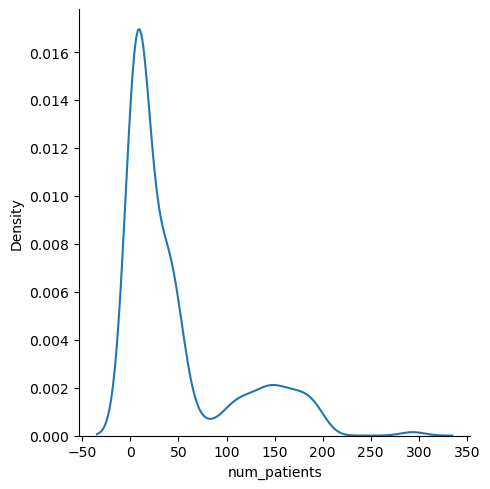

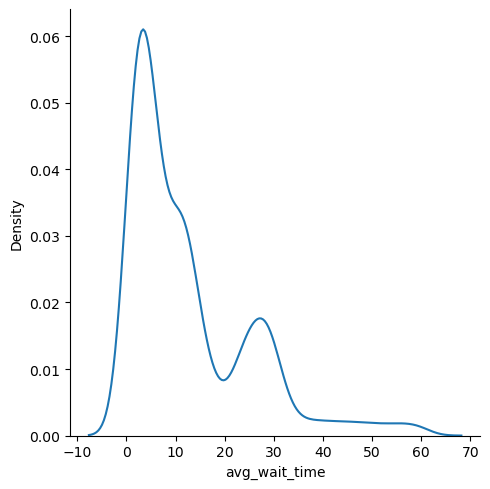

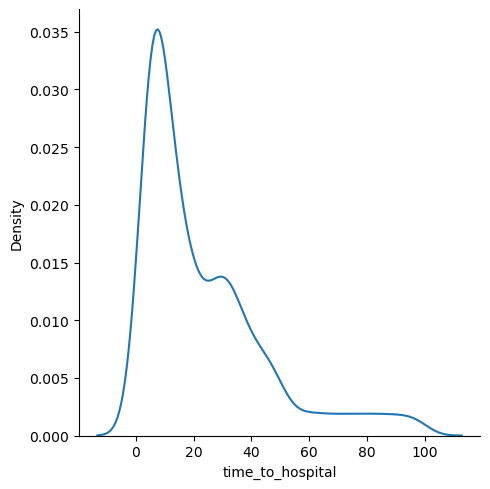

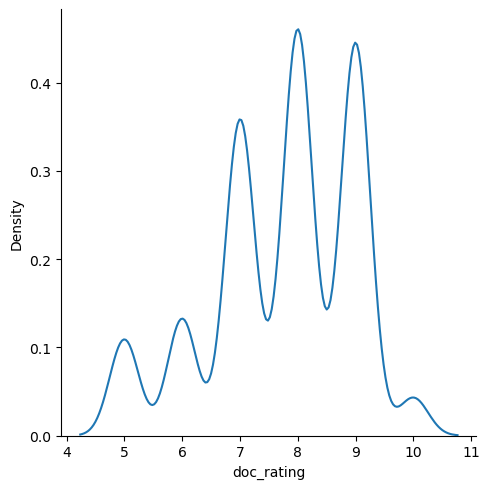

In [5]:
# checking distribution of the data
for i in cols[1:-1]:
  sns.displot(df[i],kind="kde")

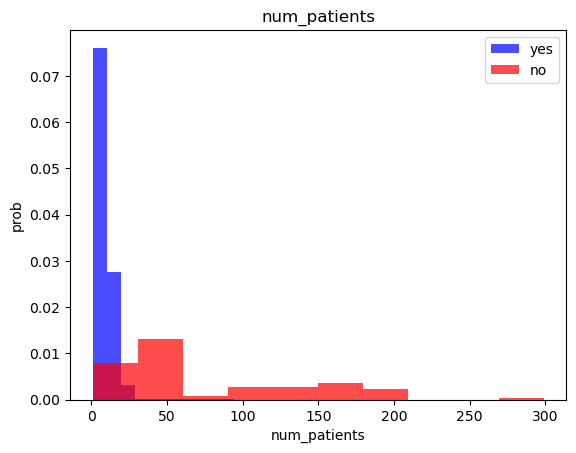

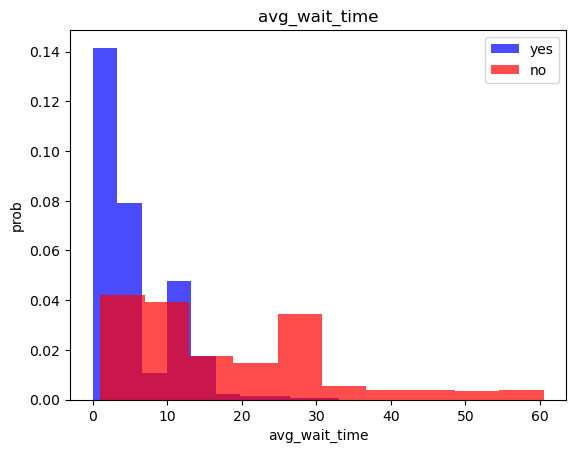

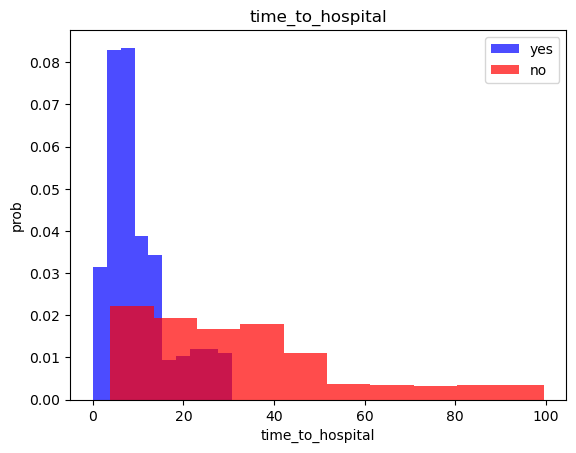

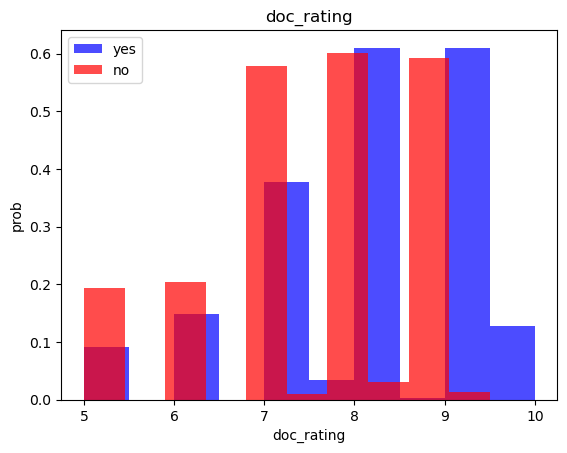

In [6]:
for l in cols[1:-1]:
    plt.hist(df[df["can_go"]==1][l],color="blue",label="yes",alpha=0.7,density=True)
    plt.hist(df[df["can_go"]==0][l],color="red",label="no",alpha=0.7,density=True)
    plt.title(l)
    plt.ylabel("prob")
    plt.xlabel(l)
    plt.legend()
    plt.show()

# CONCLUSION

we can see dataset is now clean and well distributed which is good for our usecase .

# PREPARING DATASET

Now let us create `train`,`test` and `validation` dataset by spliting the whole dataset in 3 parts with a split percentage of `75%,15%,15%`

In [7]:
# spliting
train,valid,test = np.split(df.sample(frac=1),[int(0.7*len(df)),int(0.85*len(df))])

/opt/intel/oneapi/intelpython/envs/tensorflow-gpu/lib/python3.9/site-packages/numpy/core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


# scale and sampling 

we need to make sure our class:`can_go` contains equal number of zero's and one's . so we oversample our data to make the count equal

scaling is not required for the dataset we made sure of it while creating dataset . scaling is used to equalize the gap between values of each columns

In [8]:
# function to scale our data
def scale(df,os=False):
   x = df[df.columns[:-1]].values
   y = df[df.columns[-1]].values

   if os:
    ros = RandomOverSampler()
    x, y=ros.fit_resample(x,y)

   data = np.hstack((x,np.reshape(y,(-1,1))))

   return data,x,y

In [9]:
# creating the splits
train,x_train,y_train = scale(train,os=True)
valid,x_valid,y_valid = scale(valid)
test,x_test,y_test = scale(test)

In [10]:
# function to evaluate the Neural Nets loss and accuracy

def plot_history(history):
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
  ax1.plot(history.history['loss'], label='loss')
  ax1.plot(history.history['val_loss'], label='val_loss')
  ax1.set_xlabel('Epoch')
  ax1.set_ylabel('Binary crossentropy')
  ax1.grid(True)

  ax2.plot(history.history['accuracy'], label='accuracy')
  ax2.plot(history.history['val_accuracy'], label='val_accuracy')
  ax2.set_xlabel('Epoch')
  ax2.set_ylabel('Accuracy')
  ax2.grid(True)
  plt.show()

# Model

In [11]:
# function to create the model

def train_model(X_train, y_train, num_nodes, dropout_prob, lr, batch_size, epochs):
  nn_model = tf.keras.Sequential([
      tf.keras.layers.Dense(num_nodes, activation='relu', input_shape=(4,)),
      tf.keras.layers.Dropout(dropout_prob),
      tf.keras.layers.Dense(num_nodes, activation='relu'),
      tf.keras.layers.Dropout(dropout_prob),
      tf.keras.layers.Dense(1, activation='sigmoid')
  ])

  nn_model.compile(optimizer=tf.keras.optimizers.Adam(lr), loss='binary_crossentropy',
                  metrics=['accuracy'])
  history = nn_model.fit(
    X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2, verbose=0
  )

  return nn_model, history

4 nodes, dropout 0, lr 0.01, batch size 16


2024-03-08 20:35:23.343312: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform XPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-03-08 20:35:23.343350: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:XPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: XPU, pci bus id: <undefined>)
2024-03-08 20:35:24.032577: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type CPU is enabled.


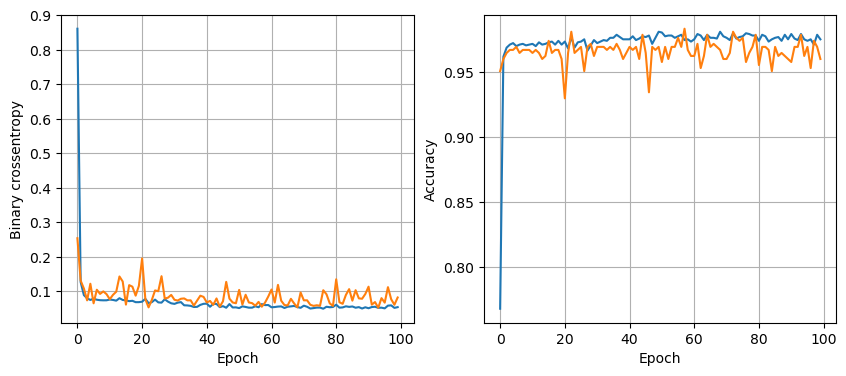

13/13 [==============================] - 0s 1ms/step - loss: 0.0858 - accuracy: 0.9653
4 nodes, dropout 0, lr 0.01, batch size 32


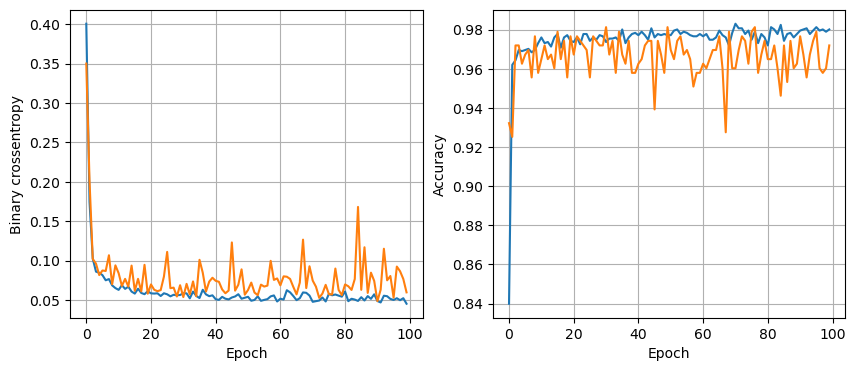

13/13 [==============================] - 0s 979us/step - loss: 0.0693 - accuracy: 0.9702
4 nodes, dropout 0, lr 0.01, batch size 64


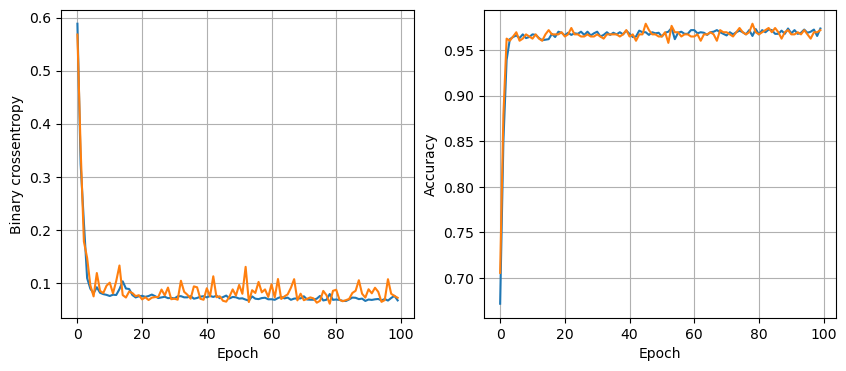

13/13 [==============================] - 0s 972us/step - loss: 0.0672 - accuracy: 0.9777
4 nodes, dropout 0, lr 0.01, batch size 128


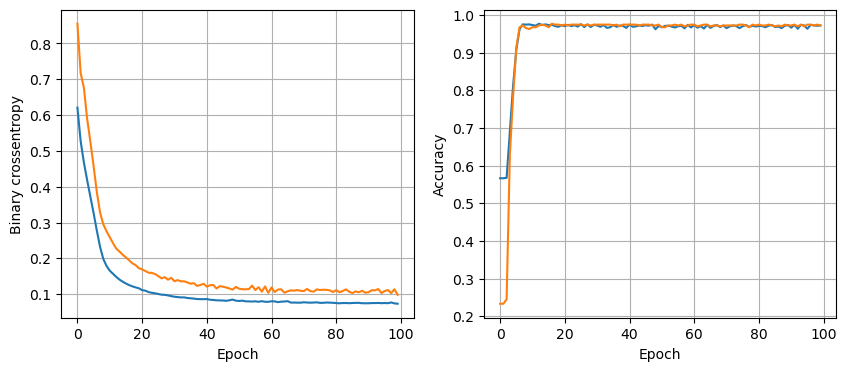

13/13 [==============================] - 0s 1ms/step - loss: 0.0860 - accuracy: 0.9553
4 nodes, dropout 0, lr 0.005, batch size 16


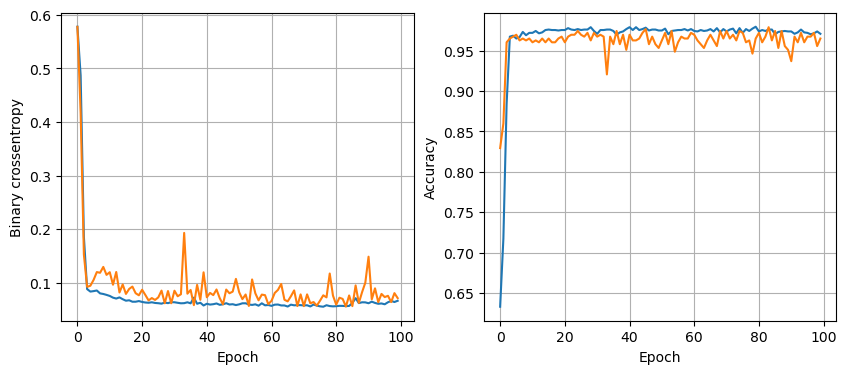

13/13 [==============================] - 0s 959us/step - loss: 0.0774 - accuracy: 0.9603
4 nodes, dropout 0, lr 0.005, batch size 32


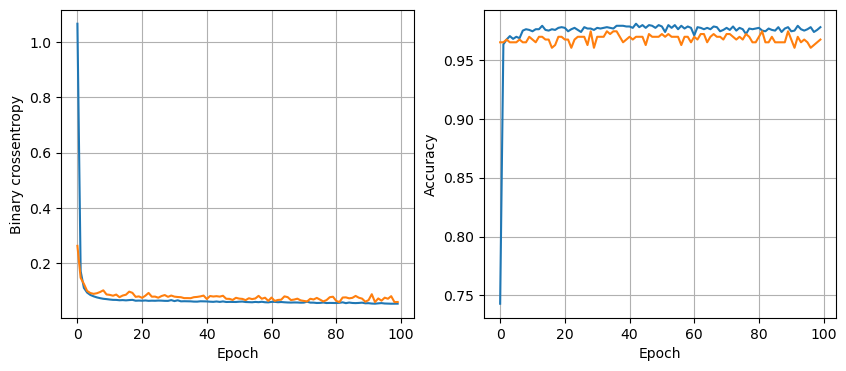

13/13 [==============================] - 0s 1ms/step - loss: 0.0883 - accuracy: 0.9603
4 nodes, dropout 0, lr 0.005, batch size 64


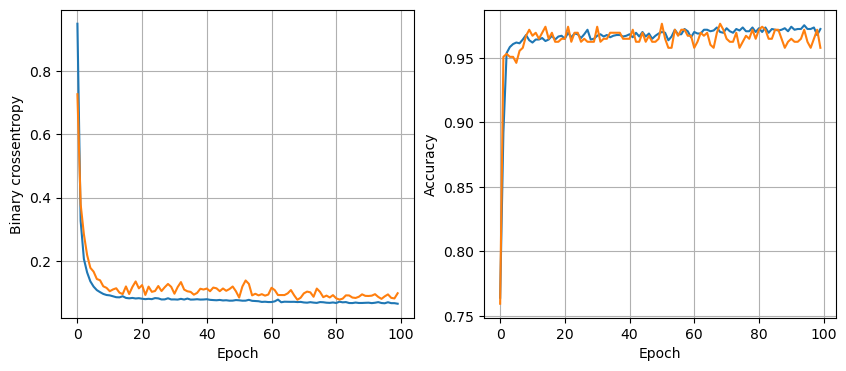

13/13 [==============================] - 0s 1ms/step - loss: 0.0776 - accuracy: 0.9702
4 nodes, dropout 0, lr 0.005, batch size 128


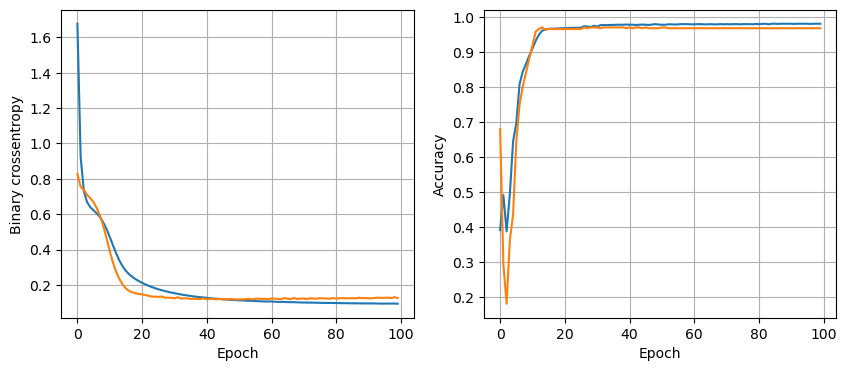

13/13 [==============================] - 0s 980us/step - loss: 0.1274 - accuracy: 0.9752
4 nodes, dropout 0, lr 0.001, batch size 16


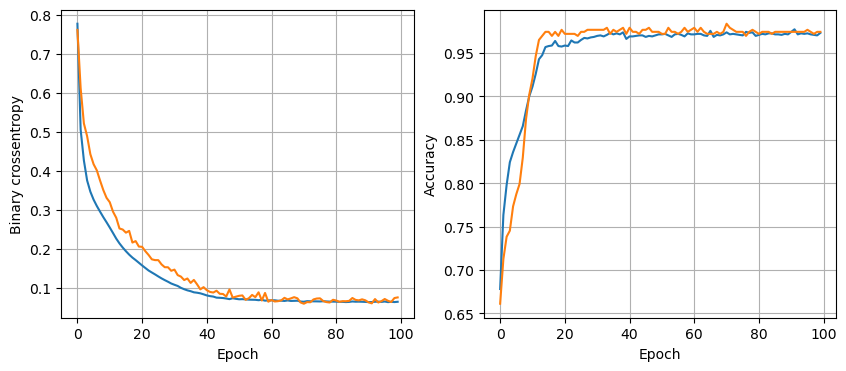

13/13 [==============================] - 0s 989us/step - loss: 0.0571 - accuracy: 0.9826
4 nodes, dropout 0, lr 0.001, batch size 32


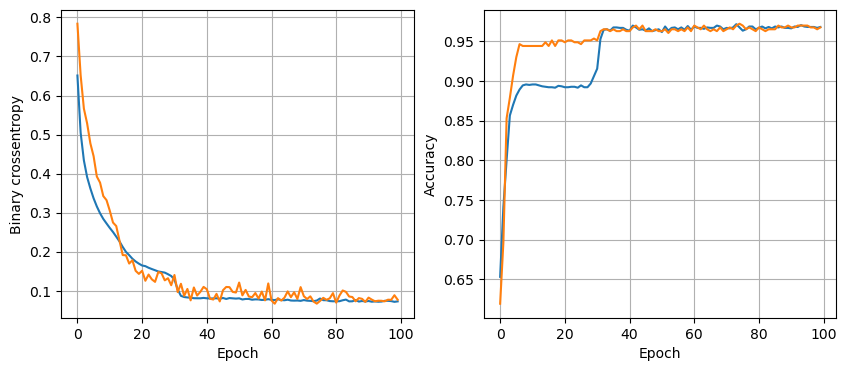

13/13 [==============================] - 0s 990us/step - loss: 0.0822 - accuracy: 0.9677
4 nodes, dropout 0, lr 0.001, batch size 64


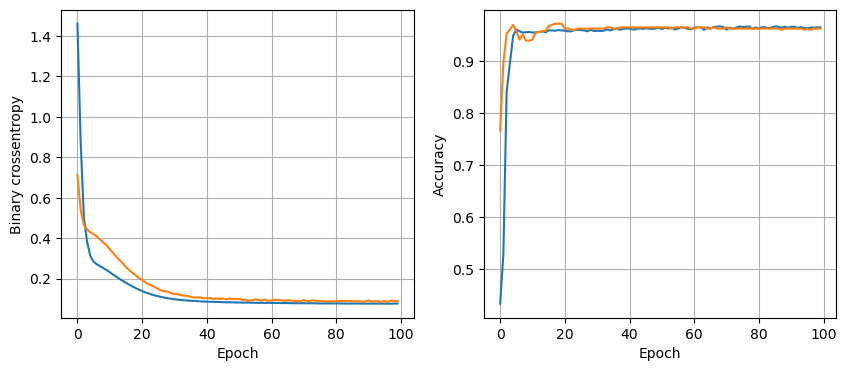

13/13 [==============================] - 0s 975us/step - loss: 0.0950 - accuracy: 0.9578
4 nodes, dropout 0, lr 0.001, batch size 128


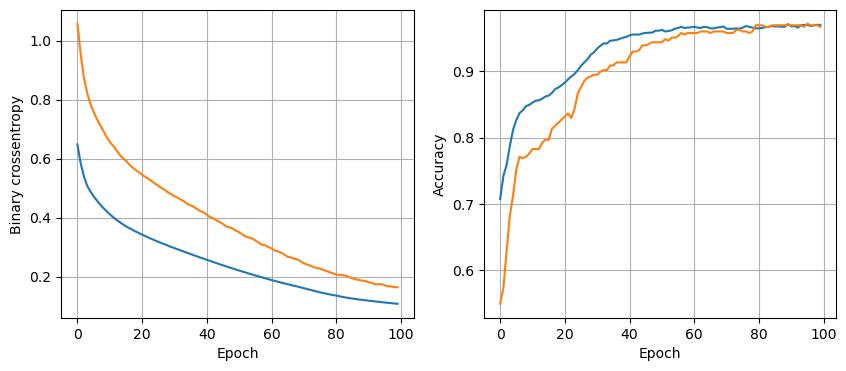

13/13 [==============================] - 0s 982us/step - loss: 0.1123 - accuracy: 0.9702
4 nodes, dropout 0.2, lr 0.01, batch size 16


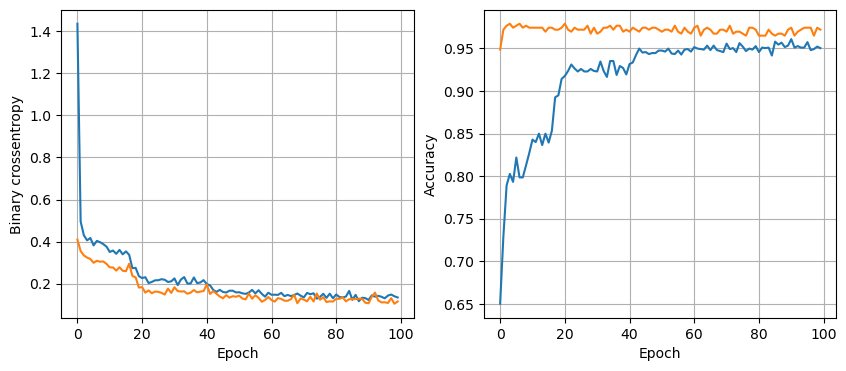

13/13 [==============================] - 0s 1ms/step - loss: 0.0984 - accuracy: 0.9553
4 nodes, dropout 0.2, lr 0.01, batch size 32


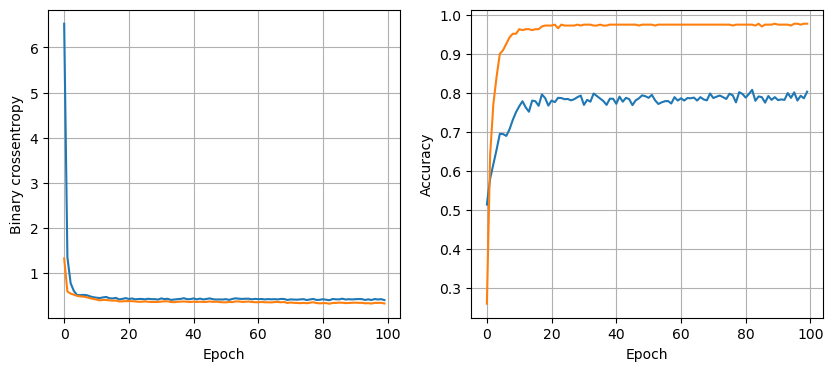

13/13 [==============================] - 0s 956us/step - loss: 0.2215 - accuracy: 0.9529
4 nodes, dropout 0.2, lr 0.01, batch size 64


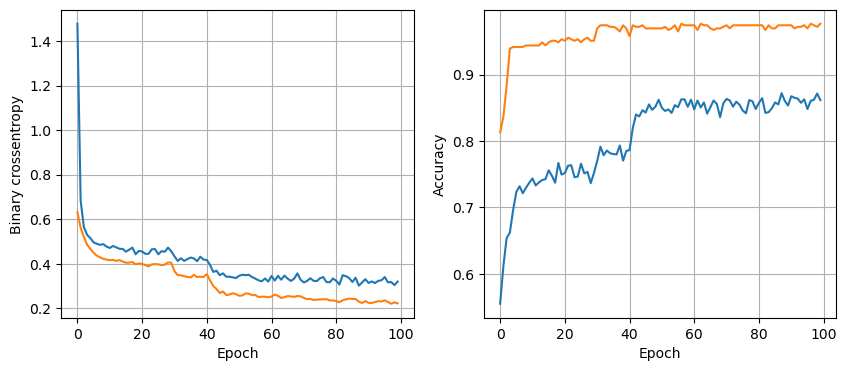

13/13 [==============================] - 0s 993us/step - loss: 0.1702 - accuracy: 0.9479
4 nodes, dropout 0.2, lr 0.01, batch size 128


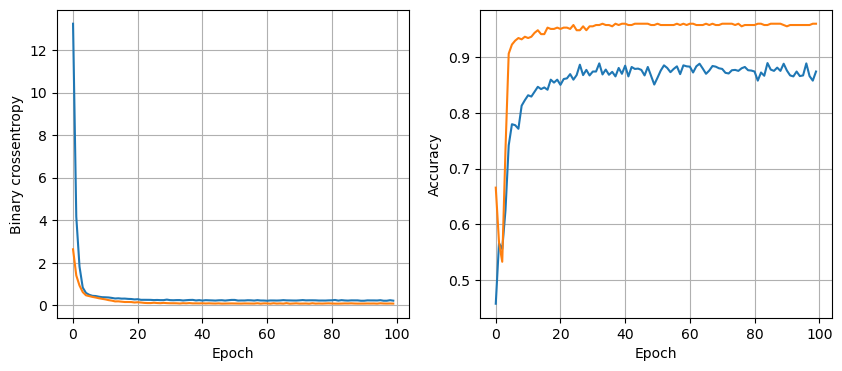

13/13 [==============================] - 0s 958us/step - loss: 0.0924 - accuracy: 0.9702
4 nodes, dropout 0.2, lr 0.005, batch size 16


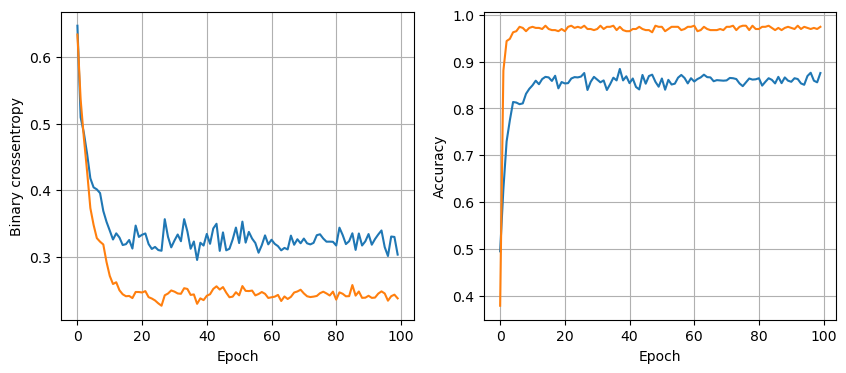

13/13 [==============================] - 0s 942us/step - loss: 0.1784 - accuracy: 0.9504
4 nodes, dropout 0.2, lr 0.005, batch size 32


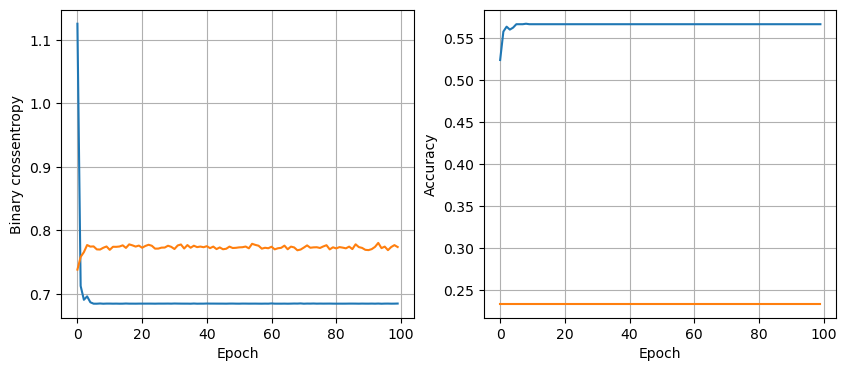

13/13 [==============================] - 0s 965us/step - loss: 0.6825 - accuracy: 0.5732
4 nodes, dropout 0.2, lr 0.005, batch size 64


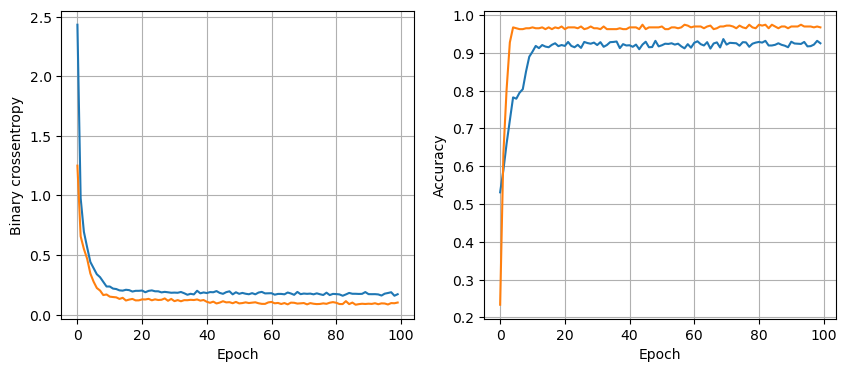

13/13 [==============================] - 0s 967us/step - loss: 0.0858 - accuracy: 0.9677
4 nodes, dropout 0.2, lr 0.005, batch size 128


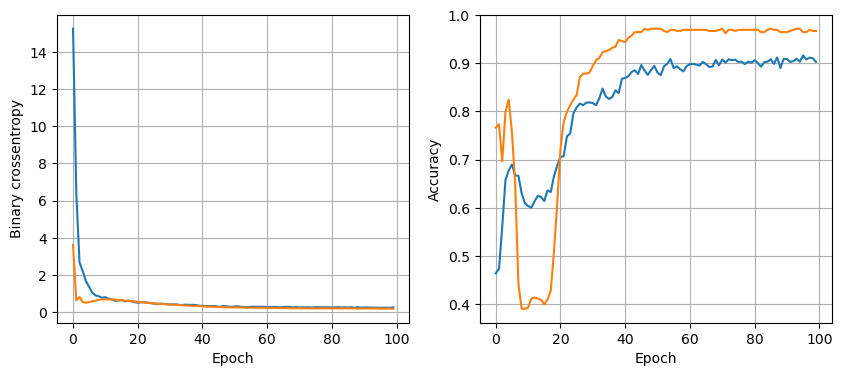

13/13 [==============================] - 0s 976us/step - loss: 0.1501 - accuracy: 0.9504
4 nodes, dropout 0.2, lr 0.001, batch size 16


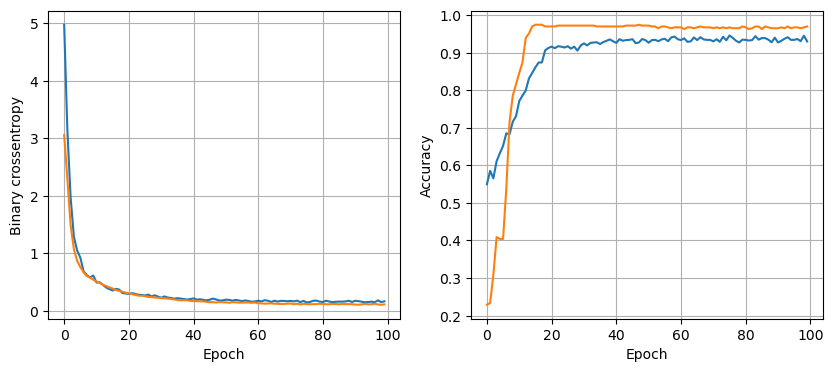

13/13 [==============================] - 0s 978us/step - loss: 0.0892 - accuracy: 0.9727
4 nodes, dropout 0.2, lr 0.001, batch size 32


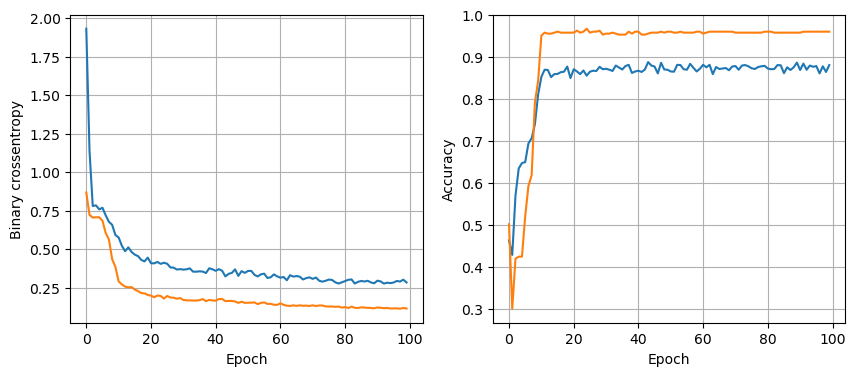

13/13 [==============================] - 0s 952us/step - loss: 0.1424 - accuracy: 0.9653
4 nodes, dropout 0.2, lr 0.001, batch size 64


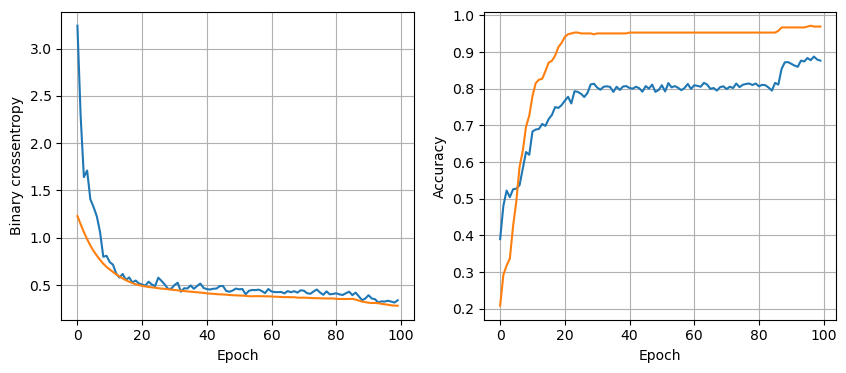

13/13 [==============================] - 0s 975us/step - loss: 0.2155 - accuracy: 0.9404
4 nodes, dropout 0.2, lr 0.001, batch size 128


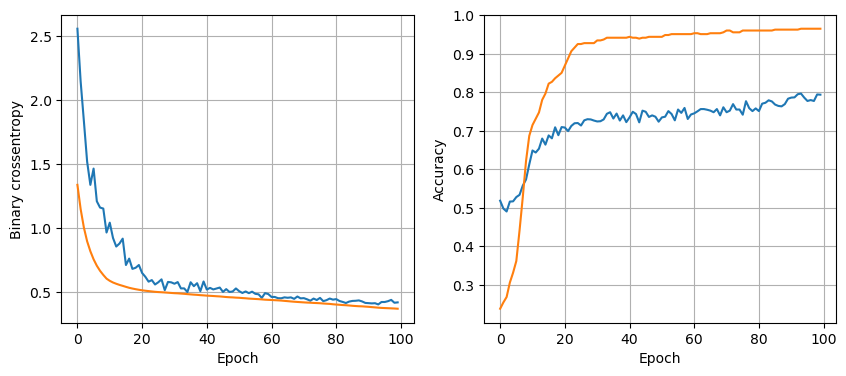

13/13 [==============================] - 0s 988us/step - loss: 0.2748 - accuracy: 0.9355
8 nodes, dropout 0, lr 0.01, batch size 16


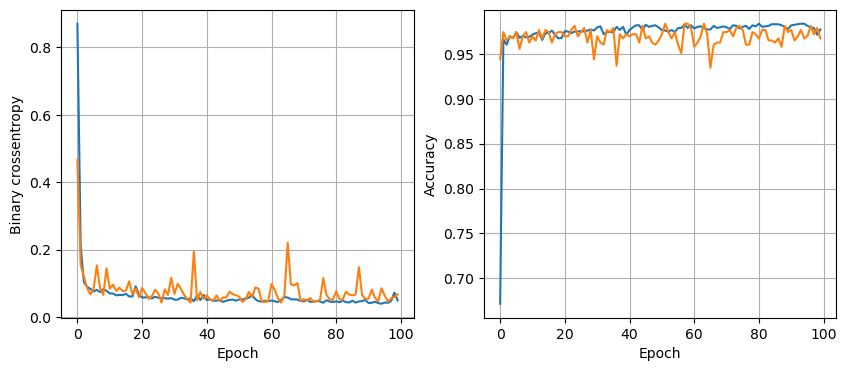

13/13 [==============================] - 0s 1ms/step - loss: 0.0772 - accuracy: 0.9702
8 nodes, dropout 0, lr 0.01, batch size 32


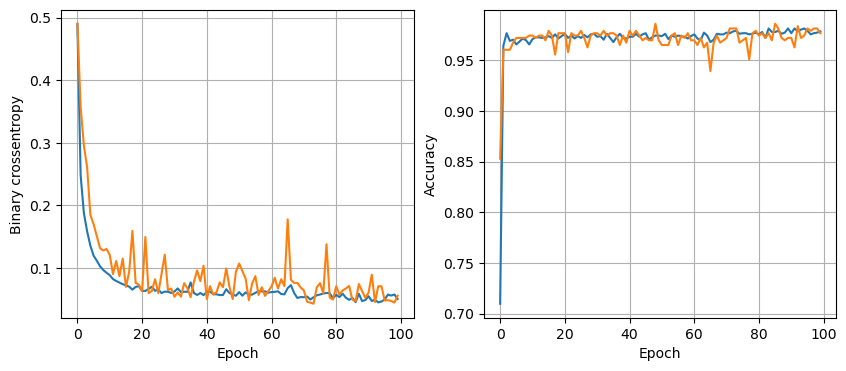

13/13 [==============================] - 0s 1ms/step - loss: 0.0625 - accuracy: 0.9752
8 nodes, dropout 0, lr 0.01, batch size 64


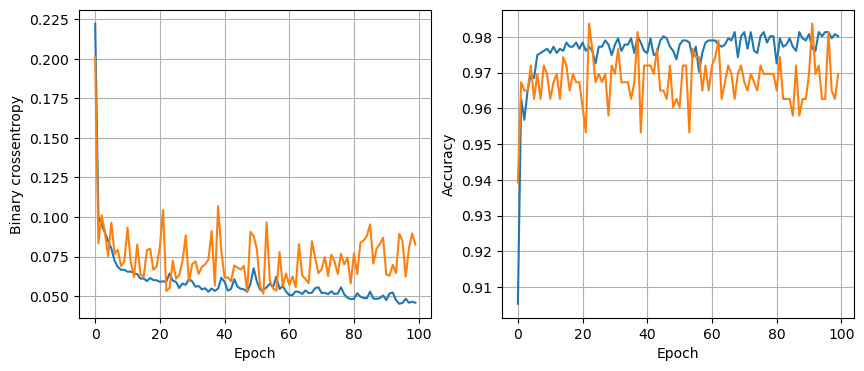

13/13 [==============================] - 0s 964us/step - loss: 0.0851 - accuracy: 0.9752
8 nodes, dropout 0, lr 0.01, batch size 128


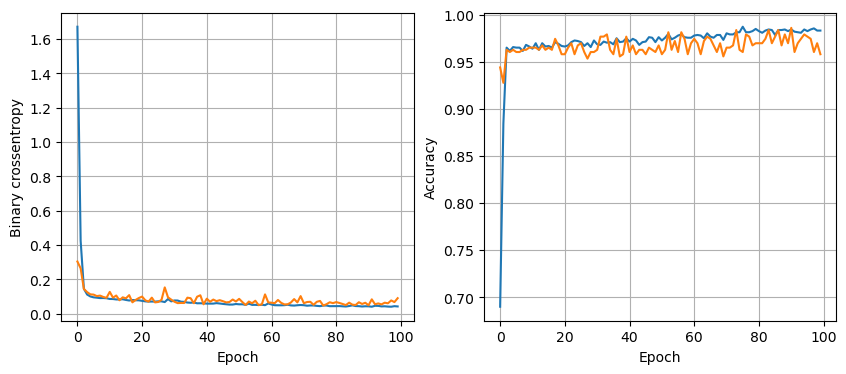

13/13 [==============================] - 0s 979us/step - loss: 0.0900 - accuracy: 0.9702
8 nodes, dropout 0, lr 0.005, batch size 16


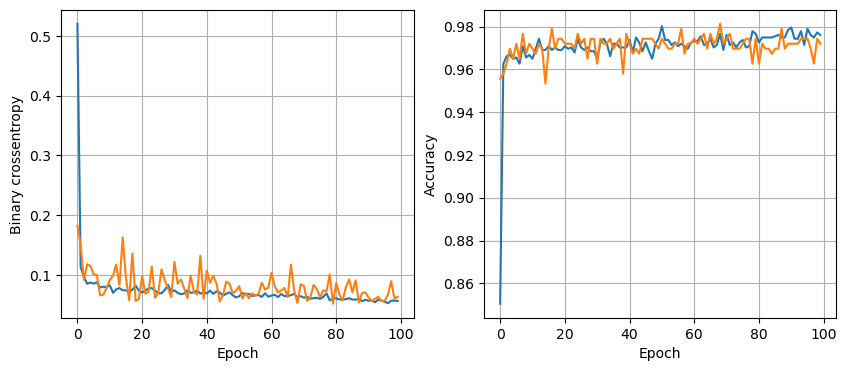

13/13 [==============================] - 0s 1ms/step - loss: 0.0757 - accuracy: 0.9653
8 nodes, dropout 0, lr 0.005, batch size 32


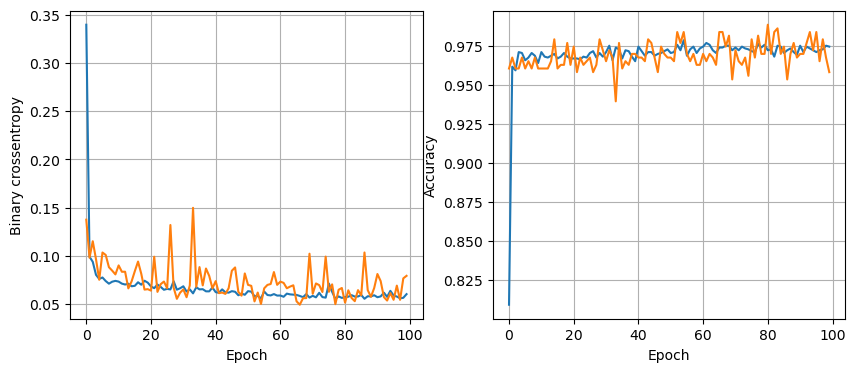

13/13 [==============================] - 0s 1ms/step - loss: 0.0627 - accuracy: 0.9752
8 nodes, dropout 0, lr 0.005, batch size 64


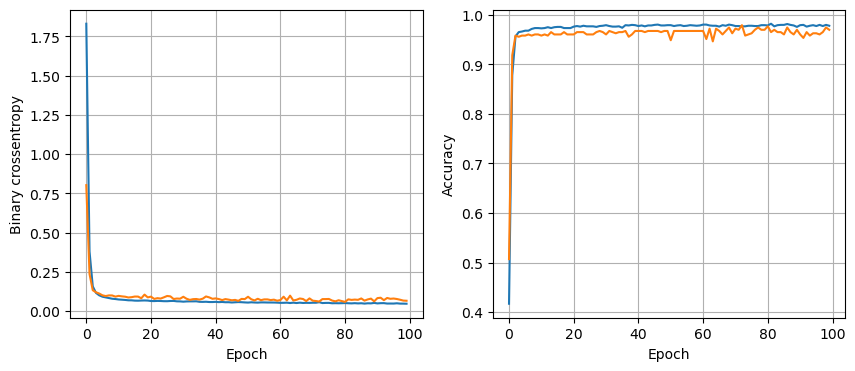

13/13 [==============================] - 0s 1ms/step - loss: 0.0702 - accuracy: 0.9702
8 nodes, dropout 0, lr 0.005, batch size 128


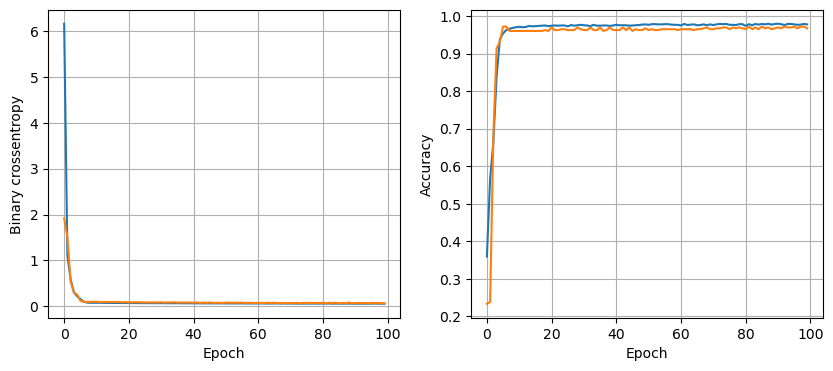

13/13 [==============================] - 0s 988us/step - loss: 0.0770 - accuracy: 0.9727
8 nodes, dropout 0, lr 0.001, batch size 16


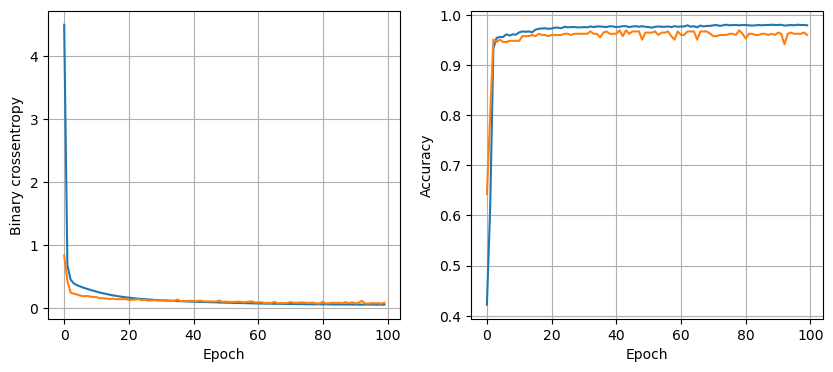

13/13 [==============================] - 0s 985us/step - loss: 0.1014 - accuracy: 0.9653
8 nodes, dropout 0, lr 0.001, batch size 32


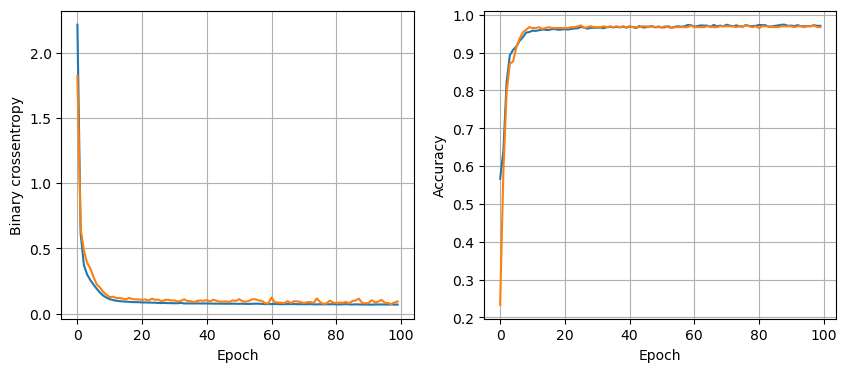

13/13 [==============================] - 0s 960us/step - loss: 0.0731 - accuracy: 0.9727
8 nodes, dropout 0, lr 0.001, batch size 64


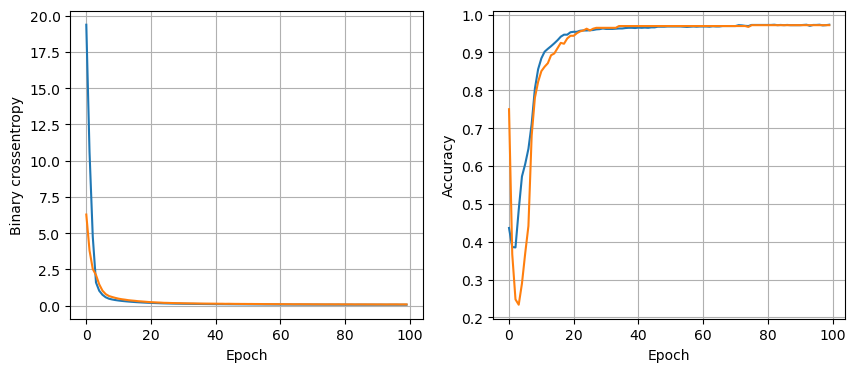

13/13 [==============================] - 0s 982us/step - loss: 0.0883 - accuracy: 0.9702
8 nodes, dropout 0, lr 0.001, batch size 128


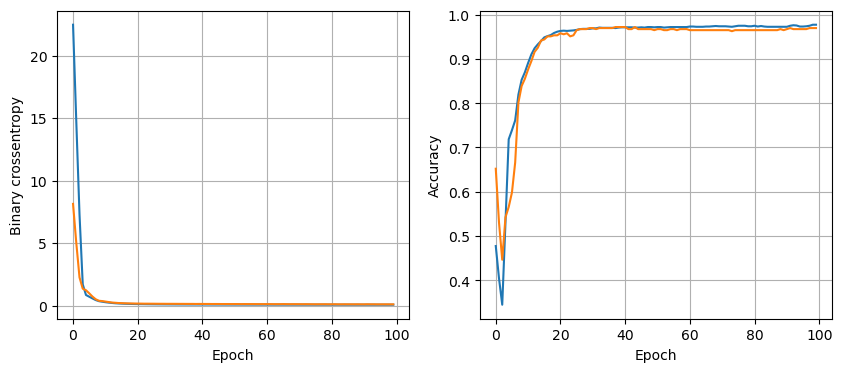

13/13 [==============================] - 0s 991us/step - loss: 0.0866 - accuracy: 0.9653
8 nodes, dropout 0.2, lr 0.01, batch size 16


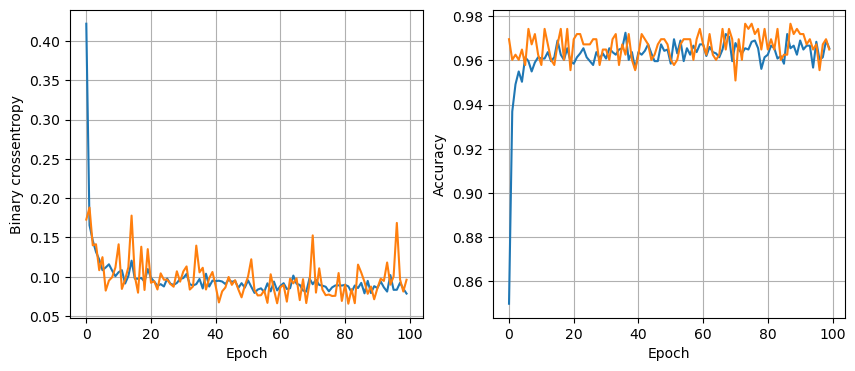

13/13 [==============================] - 0s 980us/step - loss: 0.0768 - accuracy: 0.9727
8 nodes, dropout 0.2, lr 0.01, batch size 32


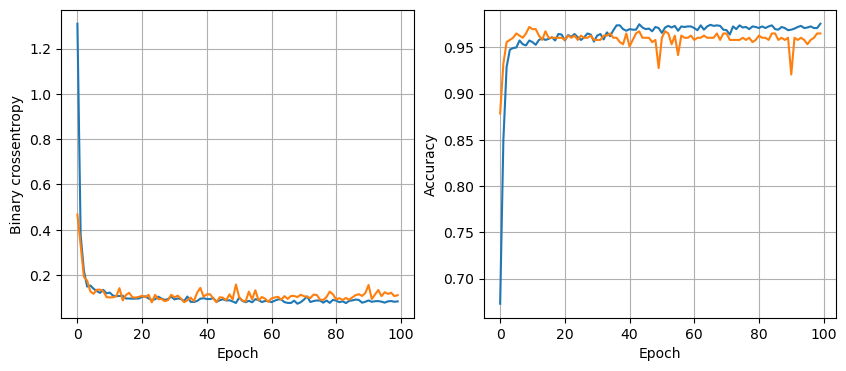

13/13 [==============================] - 0s 1ms/step - loss: 0.0752 - accuracy: 0.9752
8 nodes, dropout 0.2, lr 0.01, batch size 64


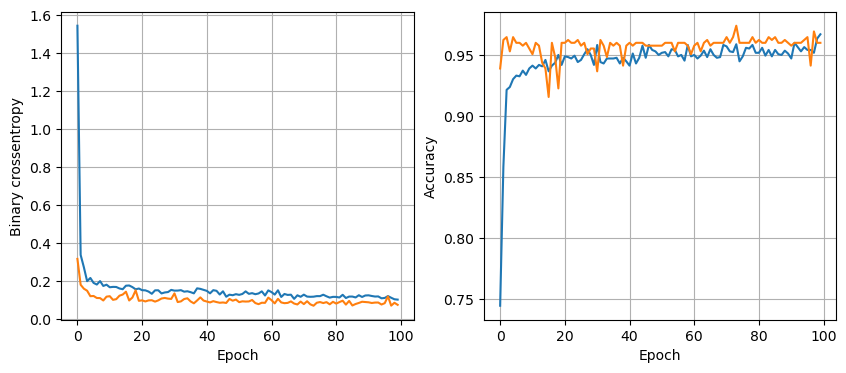

13/13 [==============================] - 0s 989us/step - loss: 0.1029 - accuracy: 0.9702
8 nodes, dropout 0.2, lr 0.01, batch size 128


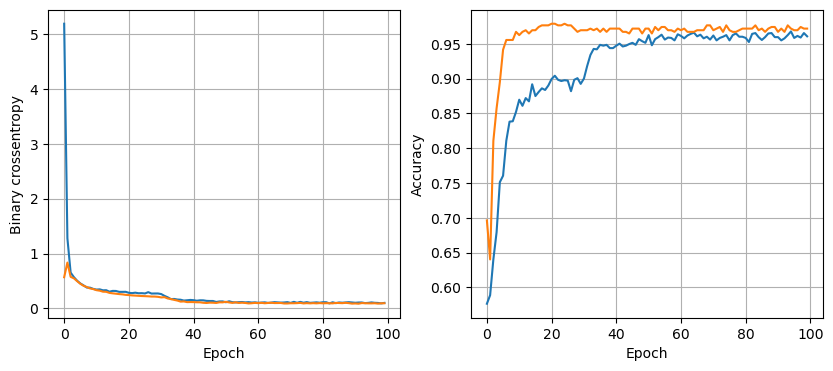

13/13 [==============================] - 0s 970us/step - loss: 0.0874 - accuracy: 0.9529
8 nodes, dropout 0.2, lr 0.005, batch size 16


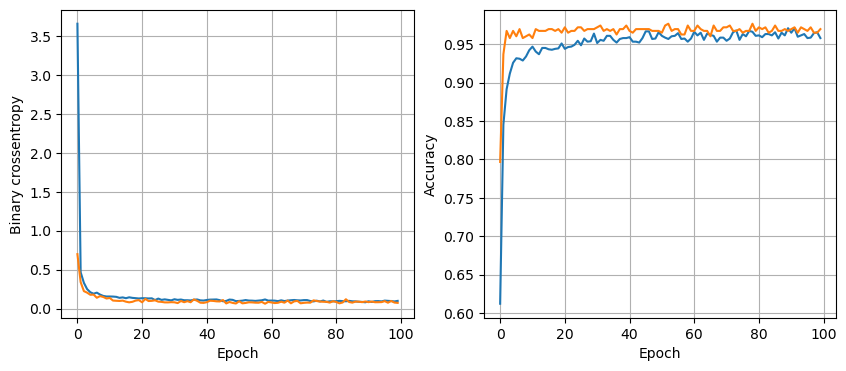

13/13 [==============================] - 0s 991us/step - loss: 0.0893 - accuracy: 0.9553
8 nodes, dropout 0.2, lr 0.005, batch size 32


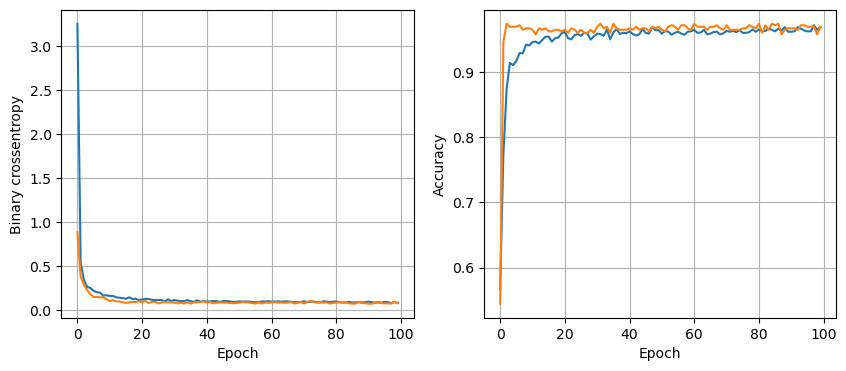

13/13 [==============================] - 0s 995us/step - loss: 0.0966 - accuracy: 0.9479
8 nodes, dropout 0.2, lr 0.005, batch size 64


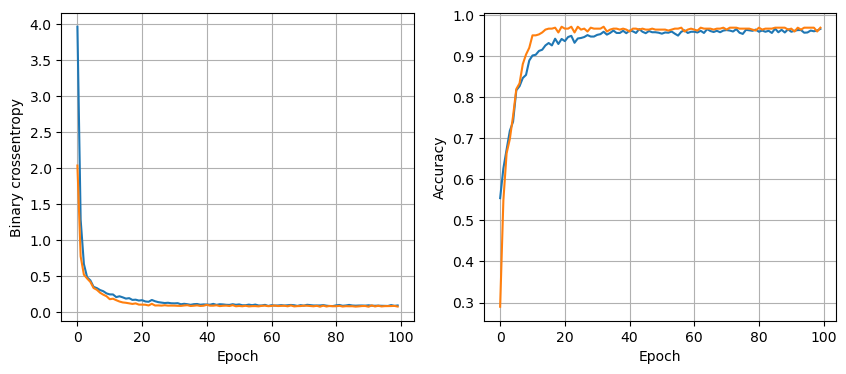

13/13 [==============================] - 0s 959us/step - loss: 0.0922 - accuracy: 0.9702
8 nodes, dropout 0.2, lr 0.005, batch size 128


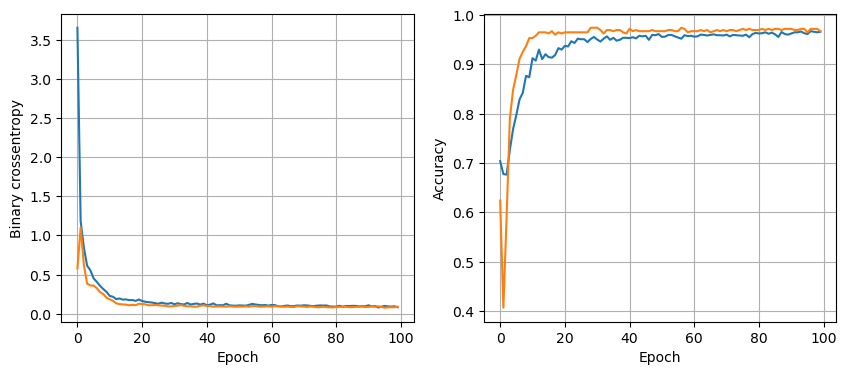

13/13 [==============================] - 0s 987us/step - loss: 0.0862 - accuracy: 0.9603
8 nodes, dropout 0.2, lr 0.001, batch size 16


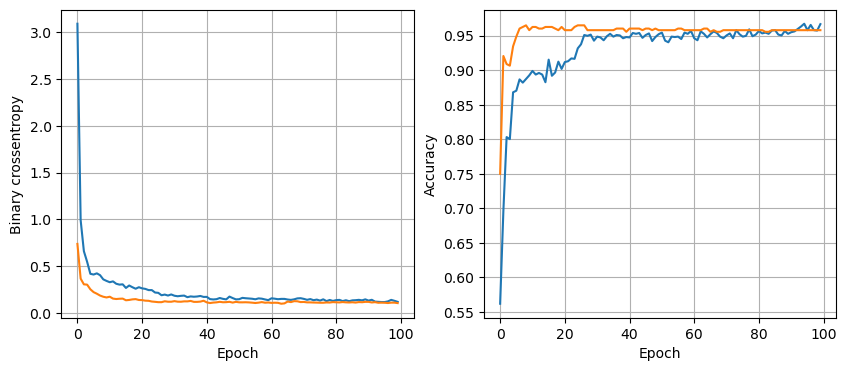

13/13 [==============================] - 0s 1ms/step - loss: 0.1051 - accuracy: 0.9653
8 nodes, dropout 0.2, lr 0.001, batch size 32


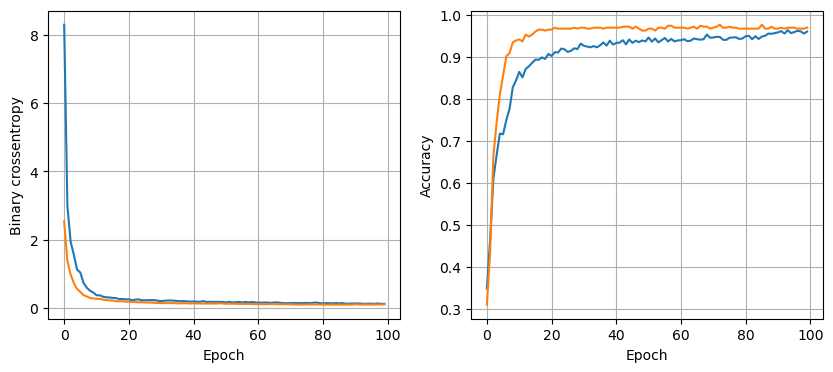

13/13 [==============================] - 0s 985us/step - loss: 0.0872 - accuracy: 0.9702
8 nodes, dropout 0.2, lr 0.001, batch size 64


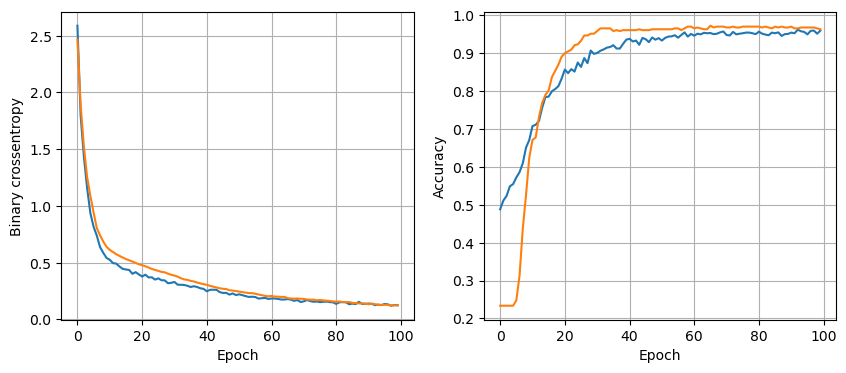

13/13 [==============================] - 0s 985us/step - loss: 0.0987 - accuracy: 0.9628
8 nodes, dropout 0.2, lr 0.001, batch size 128


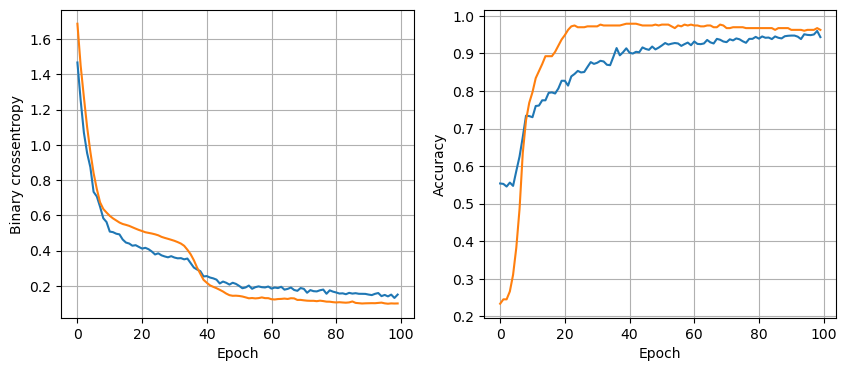

13/13 [==============================] - 0s 990us/step - loss: 0.0894 - accuracy: 0.9752
16 nodes, dropout 0, lr 0.01, batch size 16


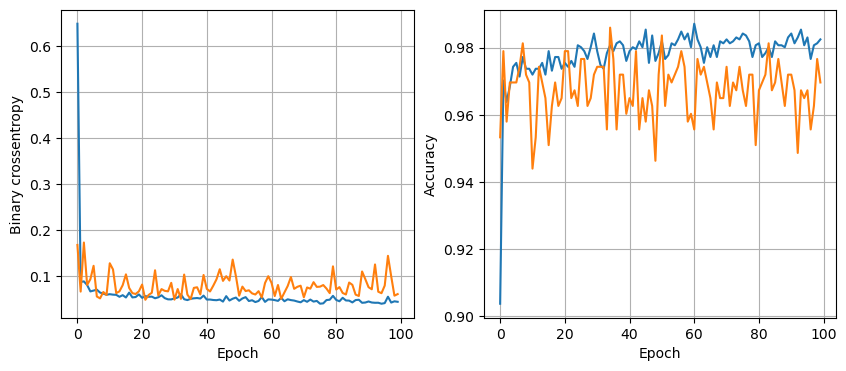

13/13 [==============================] - 0s 1ms/step - loss: 0.0987 - accuracy: 0.9727
16 nodes, dropout 0, lr 0.01, batch size 32


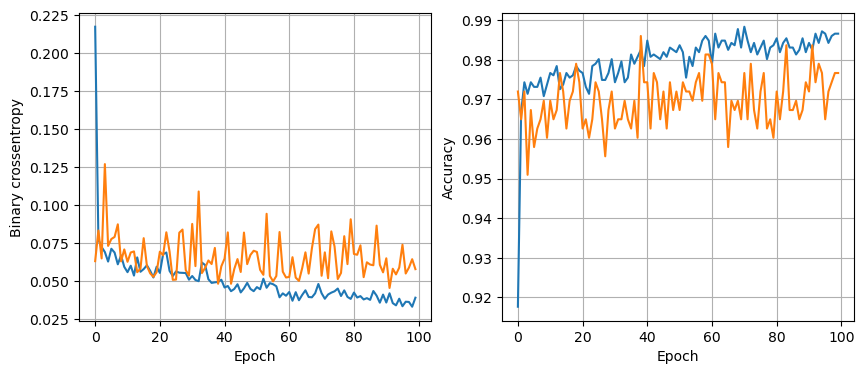

13/13 [==============================] - 0s 990us/step - loss: 0.0786 - accuracy: 0.9727
16 nodes, dropout 0, lr 0.01, batch size 64


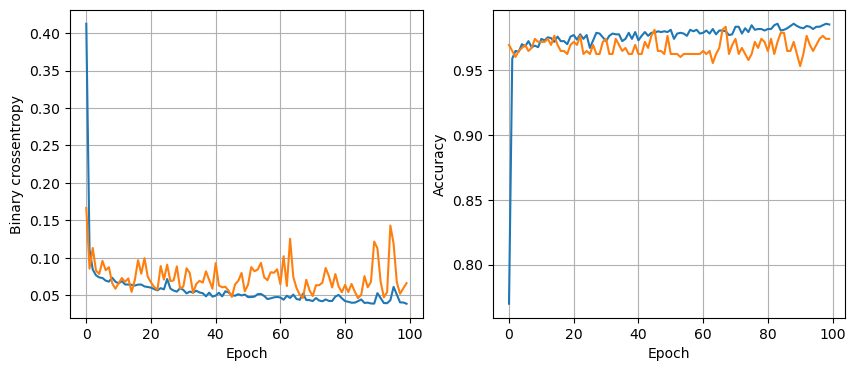

13/13 [==============================] - 0s 1ms/step - loss: 0.0784 - accuracy: 0.9702
16 nodes, dropout 0, lr 0.01, batch size 128


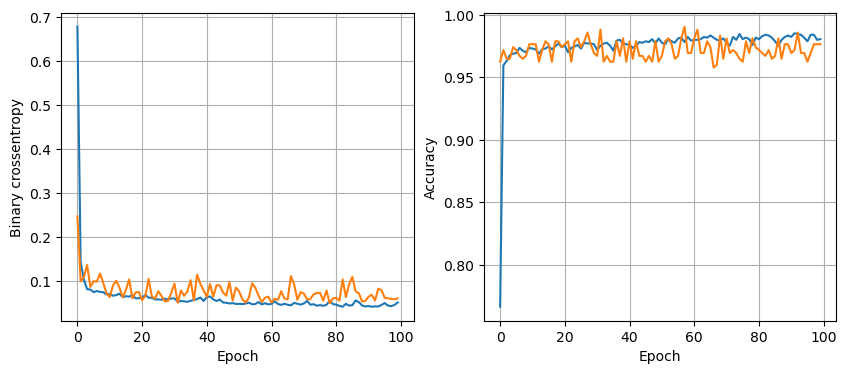

13/13 [==============================] - 0s 982us/step - loss: 0.0667 - accuracy: 0.9727
16 nodes, dropout 0, lr 0.005, batch size 16


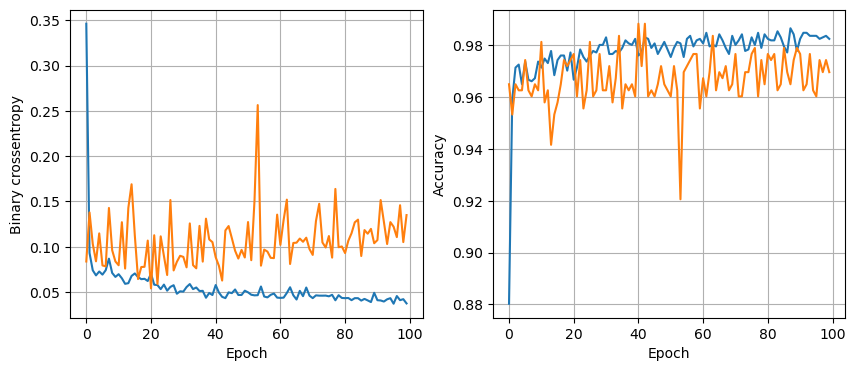

13/13 [==============================] - 0s 991us/step - loss: 0.0691 - accuracy: 0.9727
16 nodes, dropout 0, lr 0.005, batch size 32


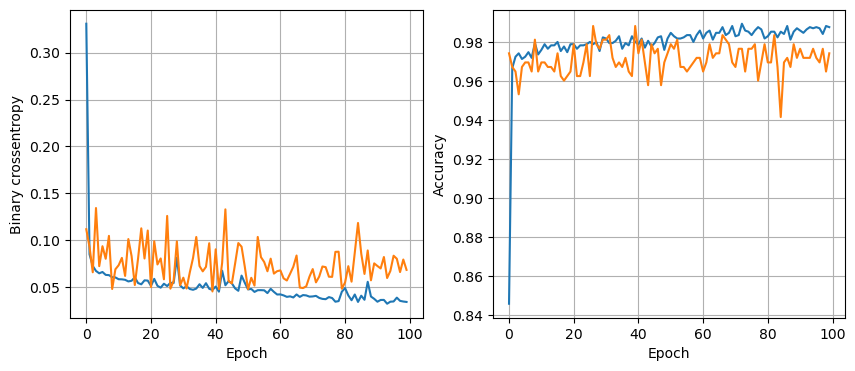

13/13 [==============================] - 0s 976us/step - loss: 0.0677 - accuracy: 0.9777
16 nodes, dropout 0, lr 0.005, batch size 64


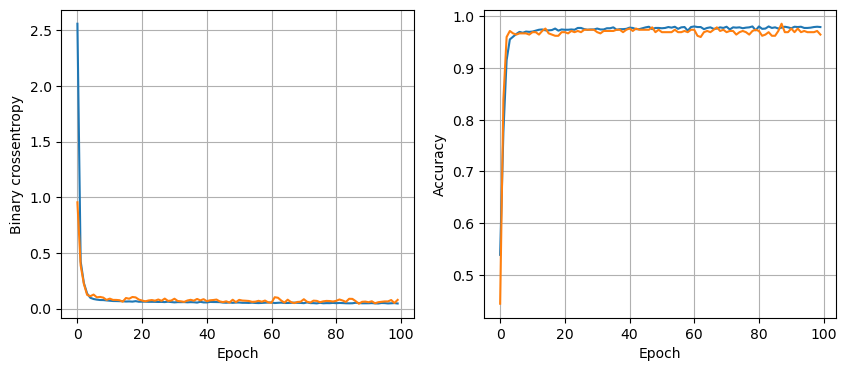

13/13 [==============================] - 0s 979us/step - loss: 0.0706 - accuracy: 0.9702
16 nodes, dropout 0, lr 0.005, batch size 128


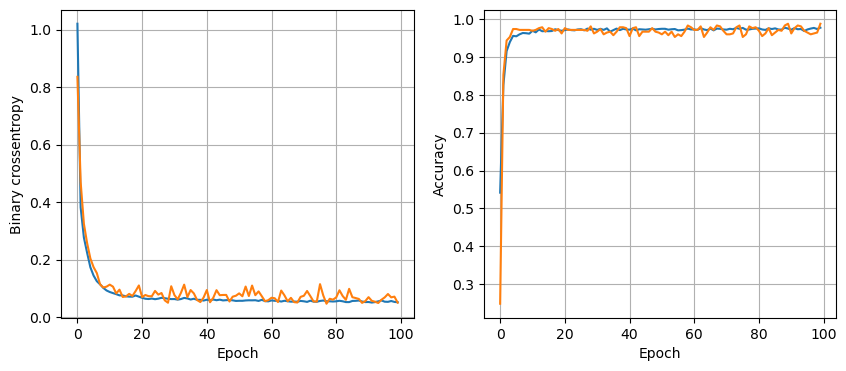

13/13 [==============================] - 0s 990us/step - loss: 0.0853 - accuracy: 0.9628
16 nodes, dropout 0, lr 0.001, batch size 16


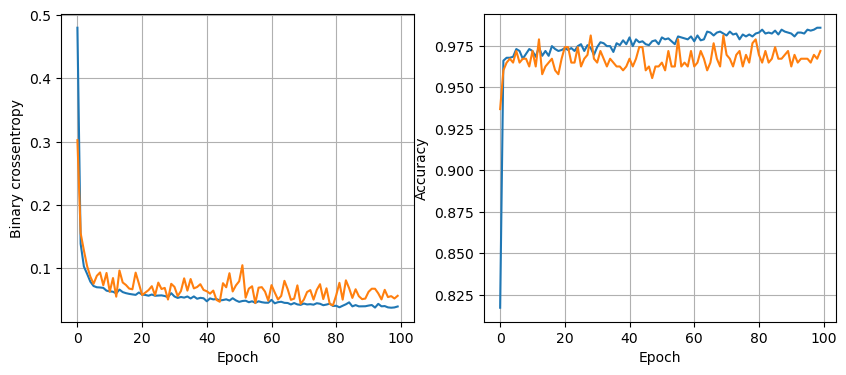

13/13 [==============================] - 0s 975us/step - loss: 0.0738 - accuracy: 0.9752
16 nodes, dropout 0, lr 0.001, batch size 32


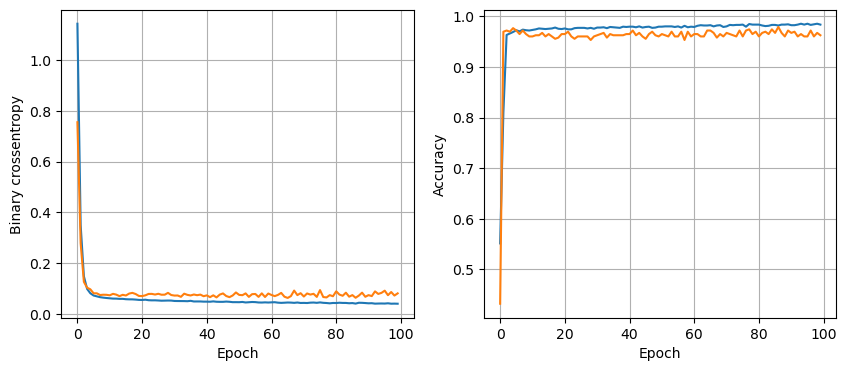

13/13 [==============================] - 0s 999us/step - loss: 0.0649 - accuracy: 0.9752
16 nodes, dropout 0, lr 0.001, batch size 64


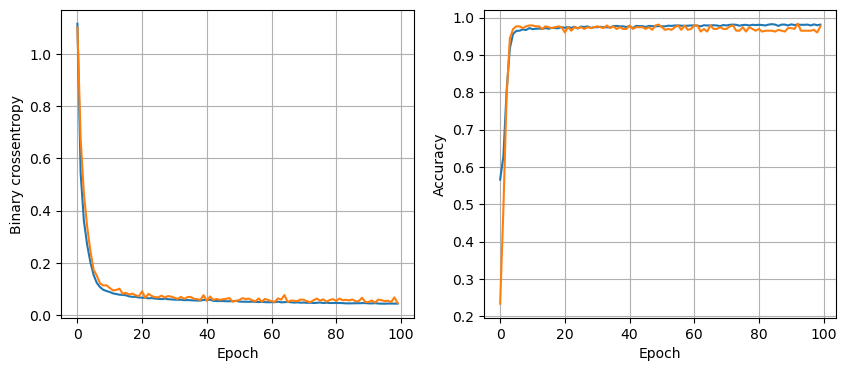

13/13 [==============================] - 0s 988us/step - loss: 0.0857 - accuracy: 0.9777
16 nodes, dropout 0, lr 0.001, batch size 128


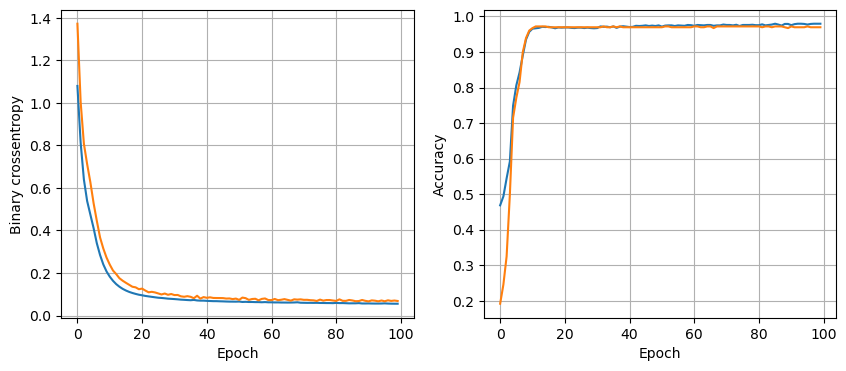

13/13 [==============================] - 0s 979us/step - loss: 0.0746 - accuracy: 0.9777
16 nodes, dropout 0.2, lr 0.01, batch size 16


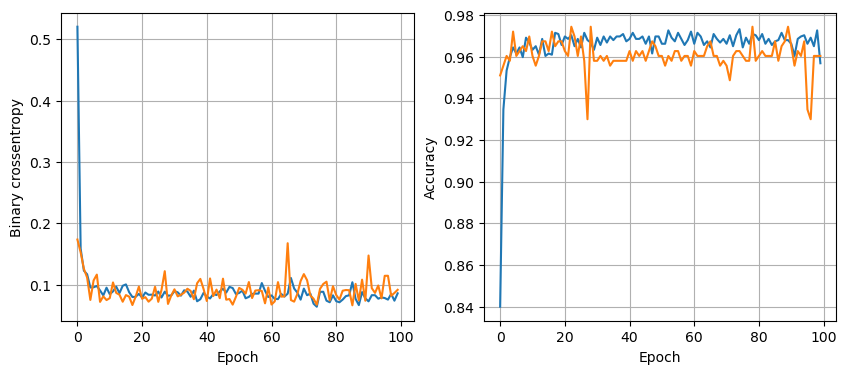

13/13 [==============================] - 0s 947us/step - loss: 0.0873 - accuracy: 0.9677
16 nodes, dropout 0.2, lr 0.01, batch size 32


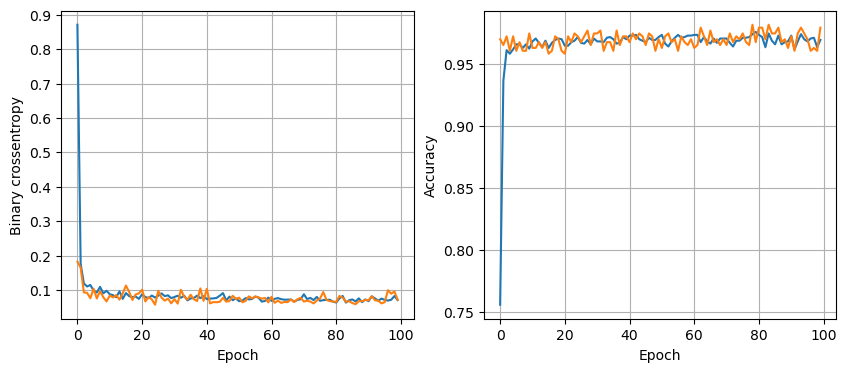

13/13 [==============================] - 0s 1ms/step - loss: 0.0733 - accuracy: 0.9752
16 nodes, dropout 0.2, lr 0.01, batch size 64


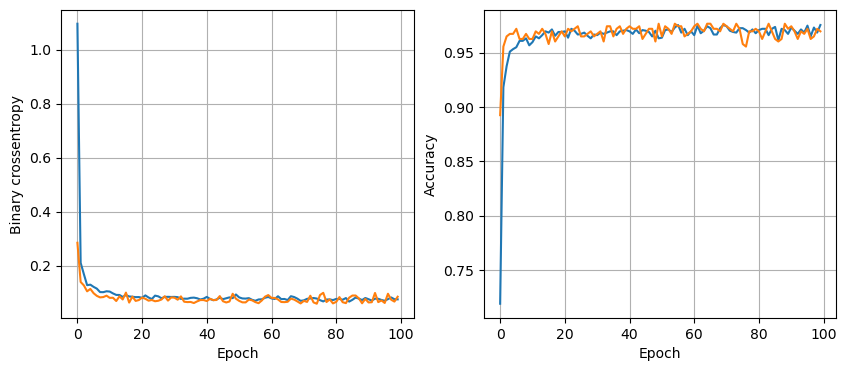

13/13 [==============================] - 0s 943us/step - loss: 0.0701 - accuracy: 0.9727
16 nodes, dropout 0.2, lr 0.01, batch size 128


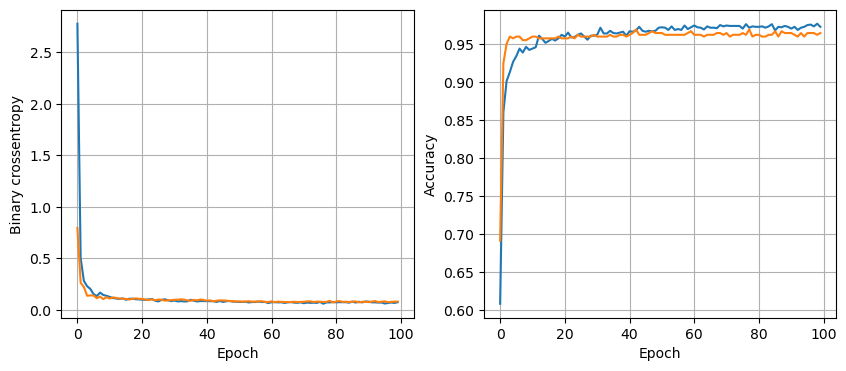

13/13 [==============================] - 0s 978us/step - loss: 0.0809 - accuracy: 0.9752
16 nodes, dropout 0.2, lr 0.005, batch size 16


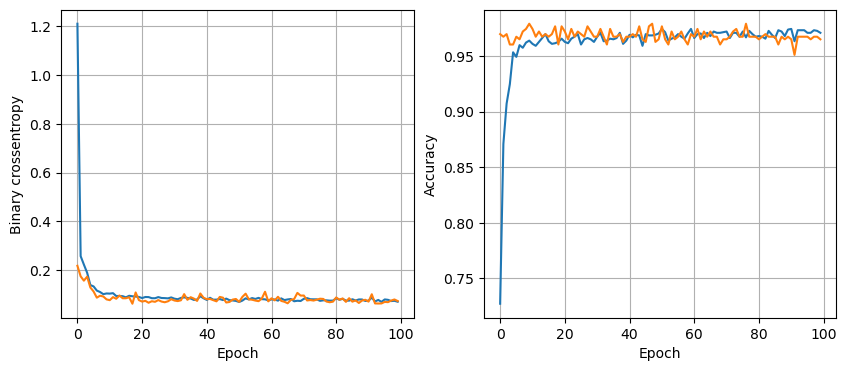

13/13 [==============================] - 0s 978us/step - loss: 0.0877 - accuracy: 0.9752
16 nodes, dropout 0.2, lr 0.005, batch size 32


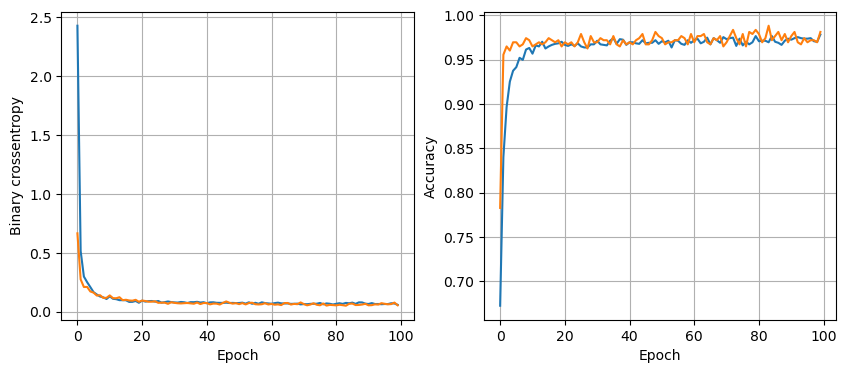

13/13 [==============================] - 0s 964us/step - loss: 0.0865 - accuracy: 0.9603
16 nodes, dropout 0.2, lr 0.005, batch size 64


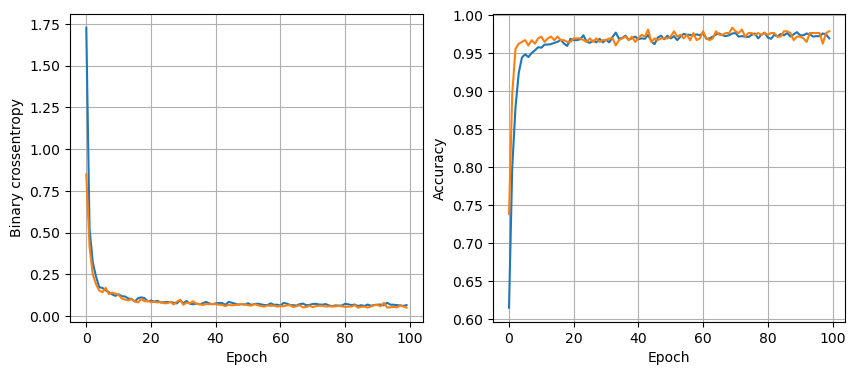

13/13 [==============================] - 0s 995us/step - loss: 0.0755 - accuracy: 0.9752
16 nodes, dropout 0.2, lr 0.005, batch size 128


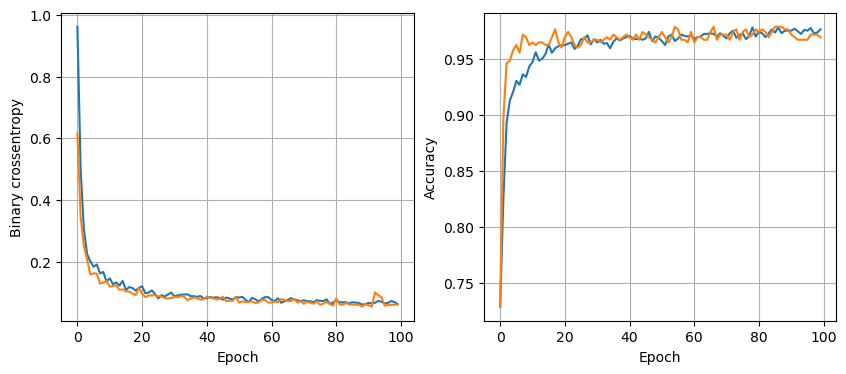

13/13 [==============================] - 0s 980us/step - loss: 0.0705 - accuracy: 0.9777
16 nodes, dropout 0.2, lr 0.001, batch size 16


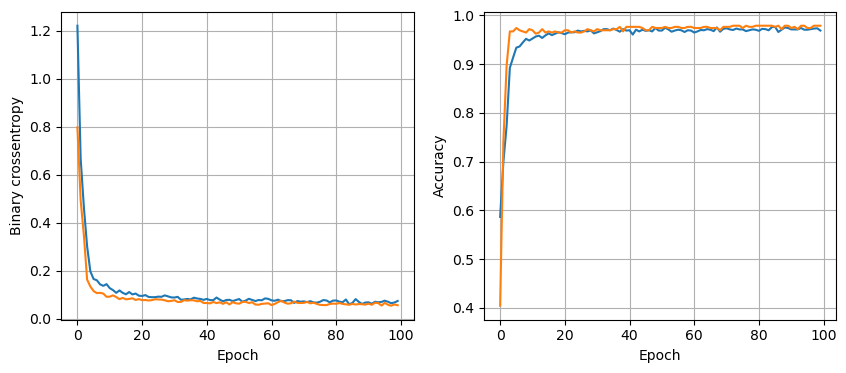

13/13 [==============================] - 0s 981us/step - loss: 0.0855 - accuracy: 0.9702
16 nodes, dropout 0.2, lr 0.001, batch size 32


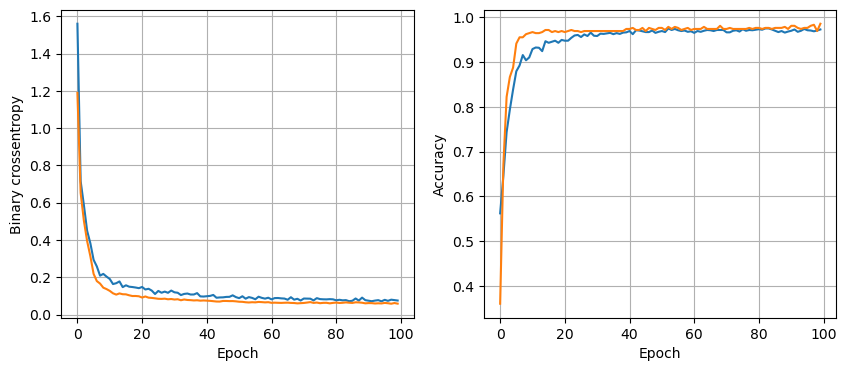

13/13 [==============================] - 0s 1ms/step - loss: 0.0794 - accuracy: 0.9677
16 nodes, dropout 0.2, lr 0.001, batch size 64


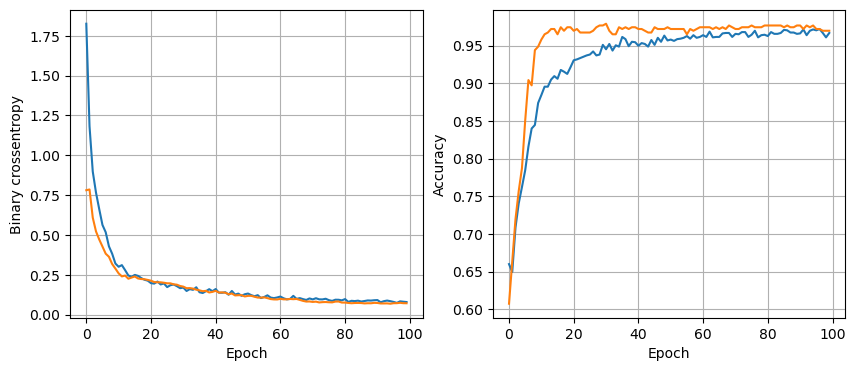

13/13 [==============================] - 0s 992us/step - loss: 0.0870 - accuracy: 0.9677
16 nodes, dropout 0.2, lr 0.001, batch size 128


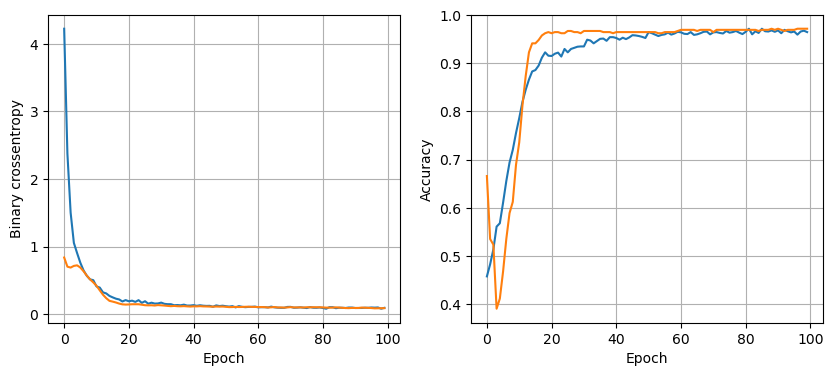

13/13 [==============================] - 0s 984us/step - loss: 0.0875 - accuracy: 0.9727
32 nodes, dropout 0, lr 0.01, batch size 16


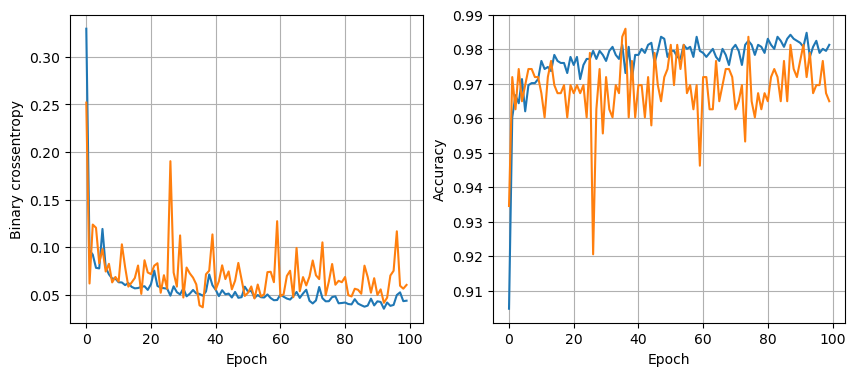

13/13 [==============================] - 0s 1ms/step - loss: 0.0986 - accuracy: 0.9702
32 nodes, dropout 0, lr 0.01, batch size 32


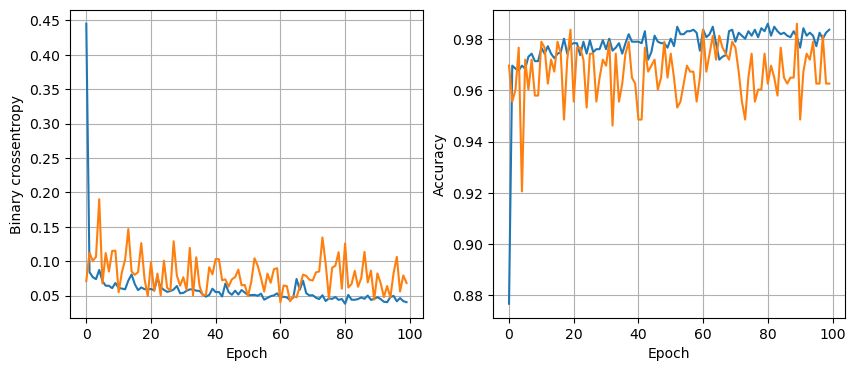

13/13 [==============================] - 0s 1ms/step - loss: 0.0621 - accuracy: 0.9801
32 nodes, dropout 0, lr 0.01, batch size 64


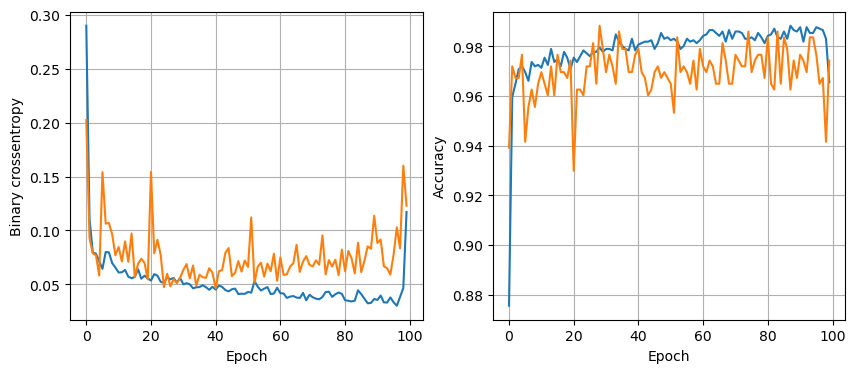

13/13 [==============================] - 0s 1ms/step - loss: 0.0790 - accuracy: 0.9702
32 nodes, dropout 0, lr 0.01, batch size 128


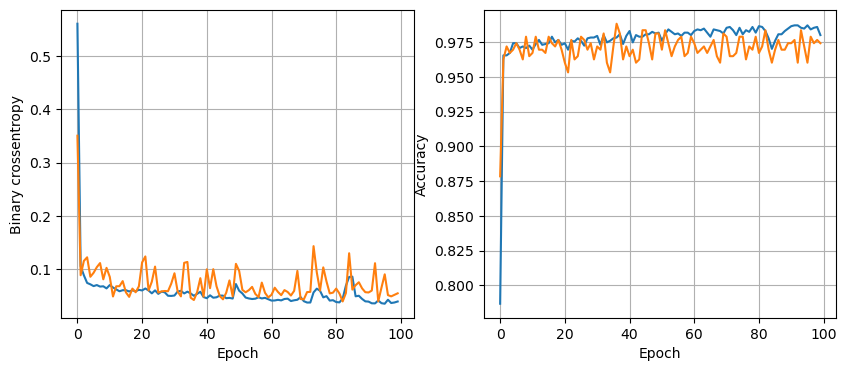

13/13 [==============================] - 0s 992us/step - loss: 0.0702 - accuracy: 0.9752
32 nodes, dropout 0, lr 0.005, batch size 16


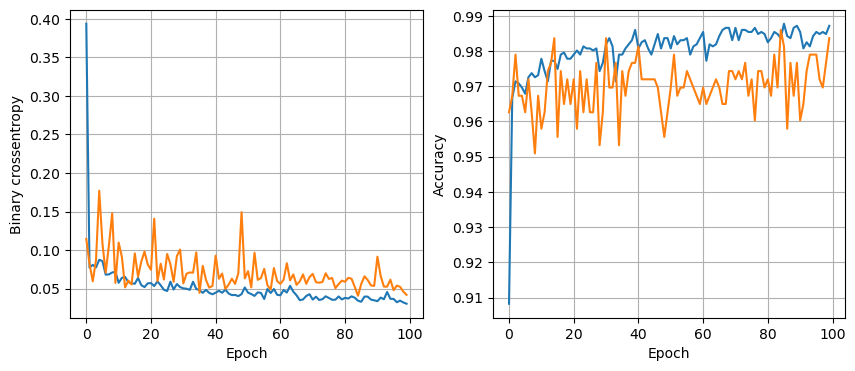

13/13 [==============================] - 0s 1ms/step - loss: 0.0992 - accuracy: 0.9777
32 nodes, dropout 0, lr 0.005, batch size 32


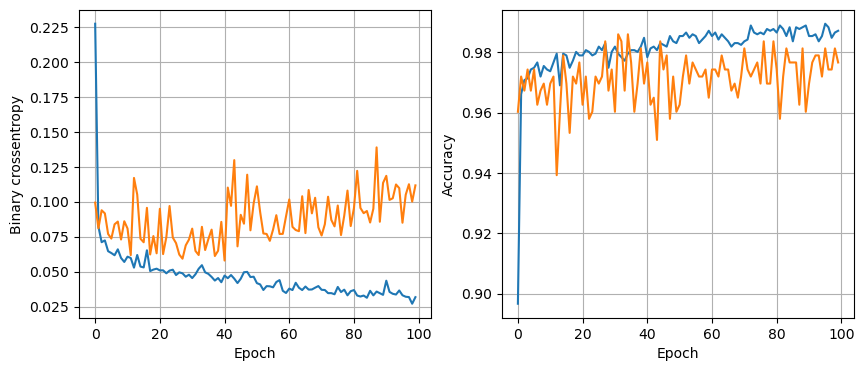

13/13 [==============================] - 0s 1ms/step - loss: 0.0926 - accuracy: 0.9801
32 nodes, dropout 0, lr 0.005, batch size 64


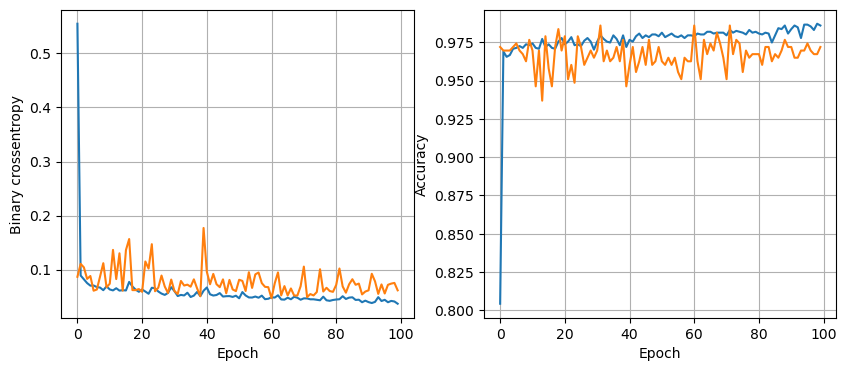

13/13 [==============================] - 0s 953us/step - loss: 0.0942 - accuracy: 0.9752
32 nodes, dropout 0, lr 0.005, batch size 128


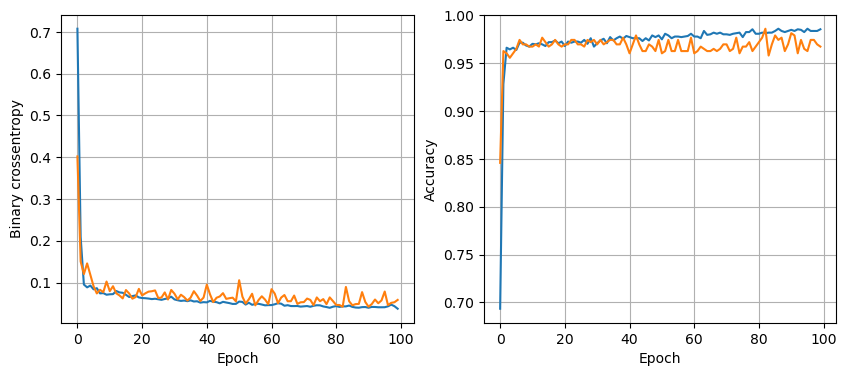

13/13 [==============================] - 0s 978us/step - loss: 0.0757 - accuracy: 0.9727
32 nodes, dropout 0, lr 0.001, batch size 16


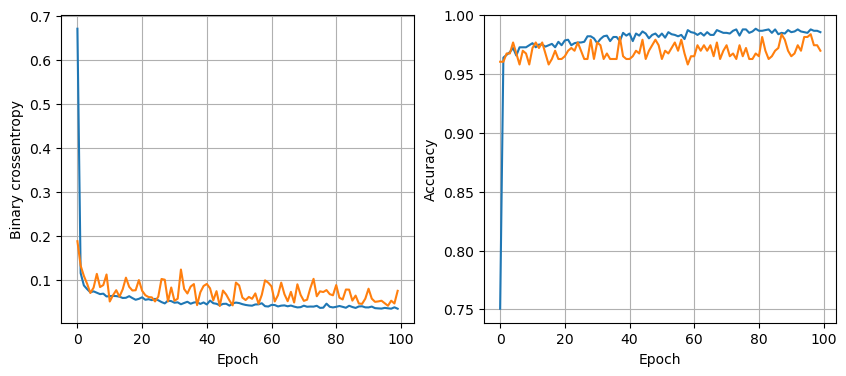

13/13 [==============================] - 0s 1ms/step - loss: 0.0548 - accuracy: 0.9727
32 nodes, dropout 0, lr 0.001, batch size 32


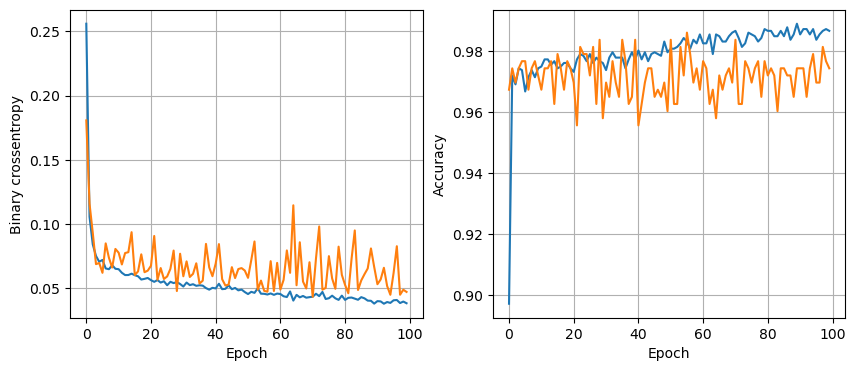

13/13 [==============================] - 0s 1ms/step - loss: 0.0805 - accuracy: 0.9752
32 nodes, dropout 0, lr 0.001, batch size 64


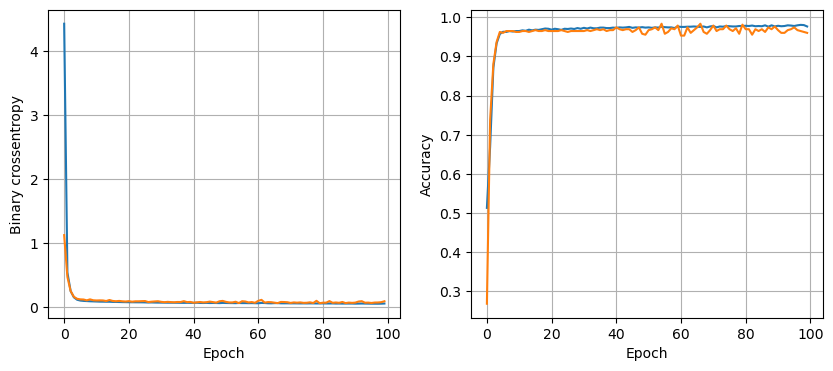

13/13 [==============================] - 0s 977us/step - loss: 0.0675 - accuracy: 0.9752
32 nodes, dropout 0, lr 0.001, batch size 128


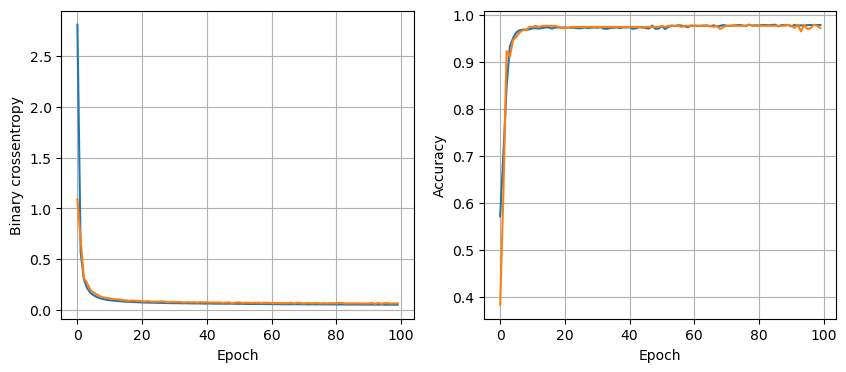

13/13 [==============================] - 0s 976us/step - loss: 0.0702 - accuracy: 0.9777
32 nodes, dropout 0.2, lr 0.01, batch size 16


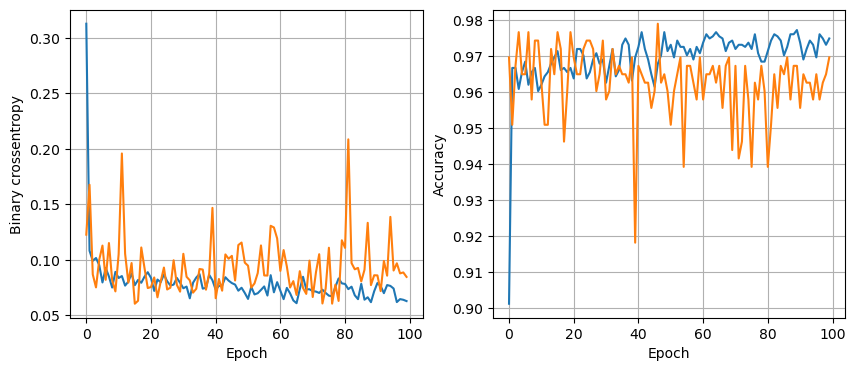

13/13 [==============================] - 0s 994us/step - loss: 0.0655 - accuracy: 0.9752
32 nodes, dropout 0.2, lr 0.01, batch size 32


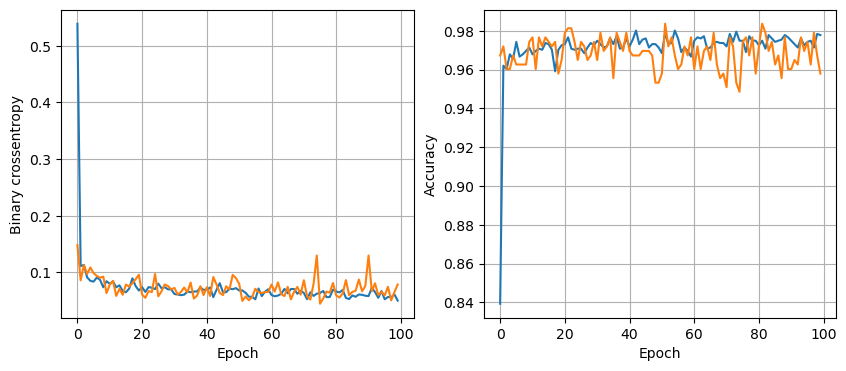

13/13 [==============================] - 0s 971us/step - loss: 0.0630 - accuracy: 0.9752
32 nodes, dropout 0.2, lr 0.01, batch size 64


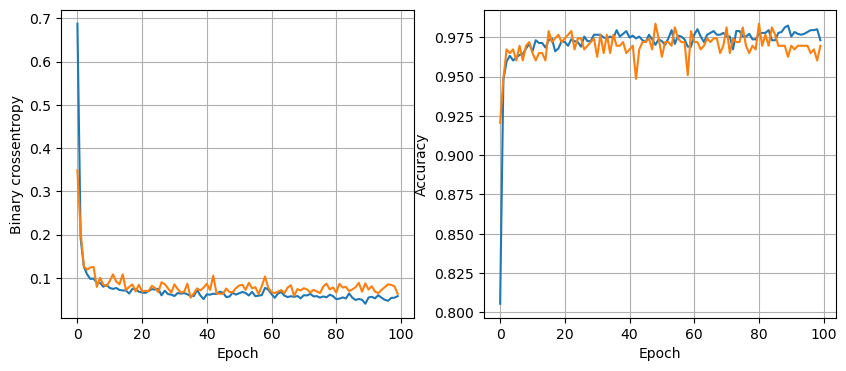

13/13 [==============================] - 0s 981us/step - loss: 0.0616 - accuracy: 0.9752
32 nodes, dropout 0.2, lr 0.01, batch size 128


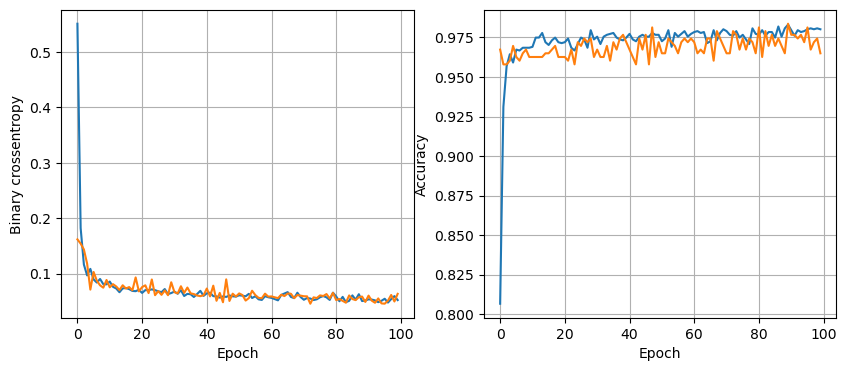

13/13 [==============================] - 0s 952us/step - loss: 0.0664 - accuracy: 0.9777
32 nodes, dropout 0.2, lr 0.005, batch size 16


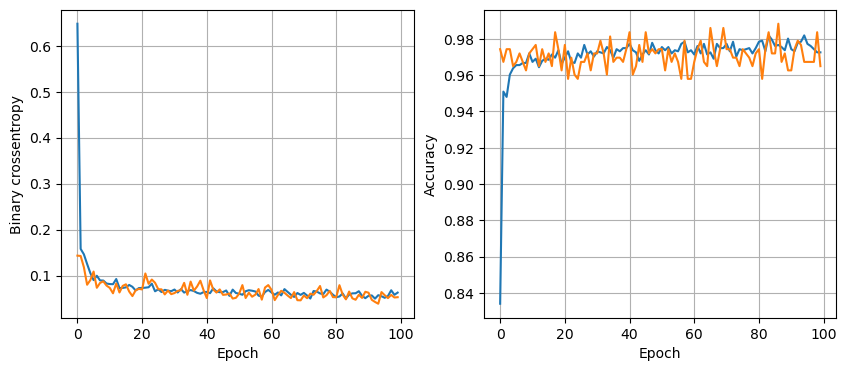

13/13 [==============================] - 0s 1ms/step - loss: 0.0667 - accuracy: 0.9801
32 nodes, dropout 0.2, lr 0.005, batch size 32


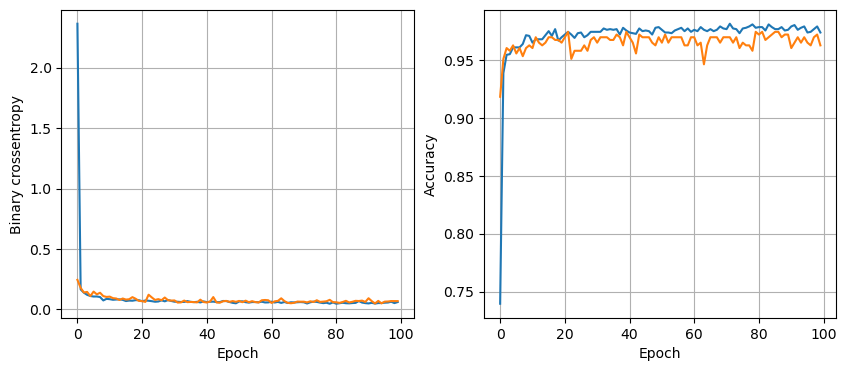

13/13 [==============================] - 0s 995us/step - loss: 0.0577 - accuracy: 0.9801
32 nodes, dropout 0.2, lr 0.005, batch size 64


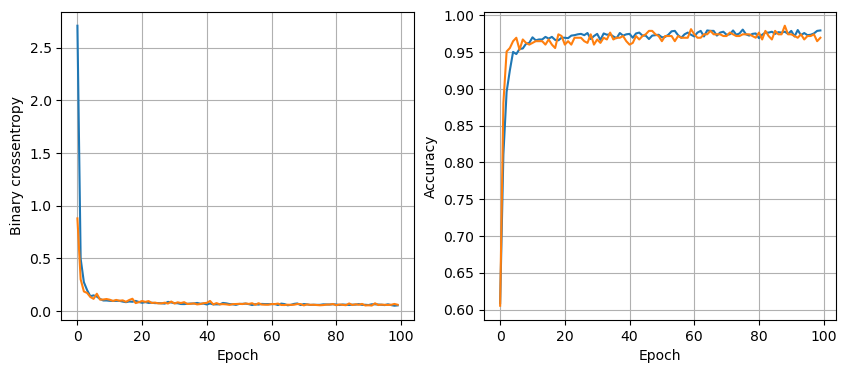

13/13 [==============================] - 0s 1ms/step - loss: 0.0638 - accuracy: 0.9752
32 nodes, dropout 0.2, lr 0.005, batch size 128


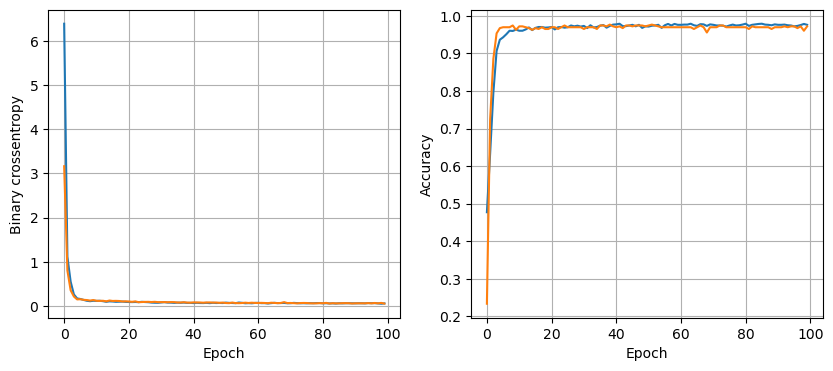

13/13 [==============================] - 0s 1ms/step - loss: 0.0824 - accuracy: 0.9752
32 nodes, dropout 0.2, lr 0.001, batch size 16


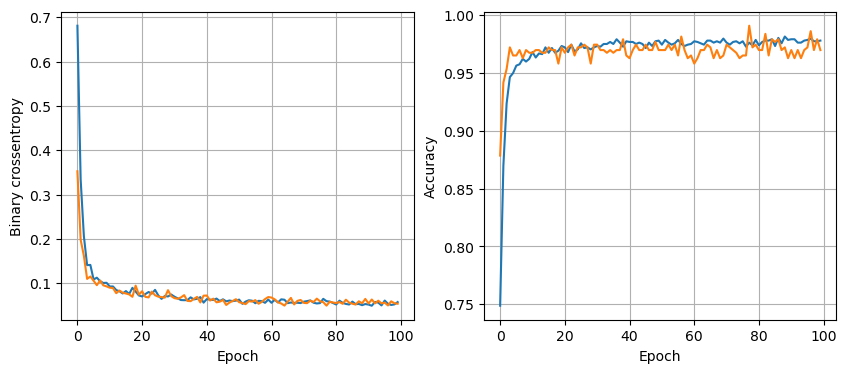

13/13 [==============================] - 0s 951us/step - loss: 0.0719 - accuracy: 0.9752
32 nodes, dropout 0.2, lr 0.001, batch size 32


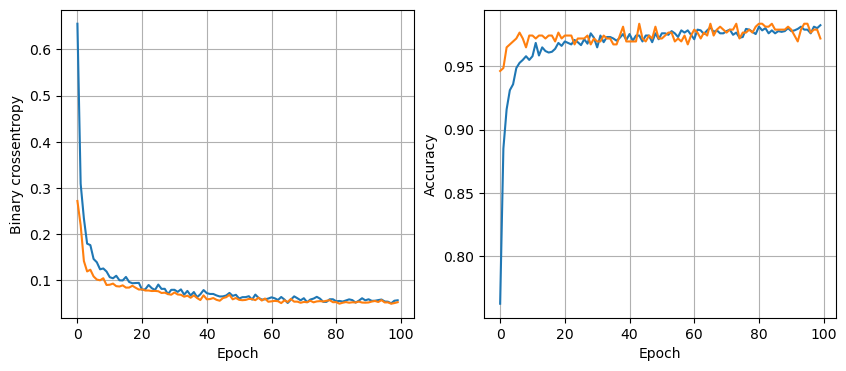

13/13 [==============================] - 0s 973us/step - loss: 0.0663 - accuracy: 0.9777
32 nodes, dropout 0.2, lr 0.001, batch size 64


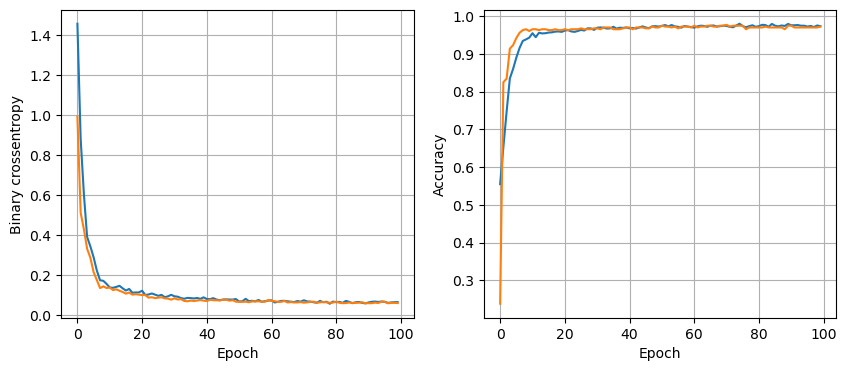

13/13 [==============================] - 0s 989us/step - loss: 0.0787 - accuracy: 0.9702
32 nodes, dropout 0.2, lr 0.001, batch size 128


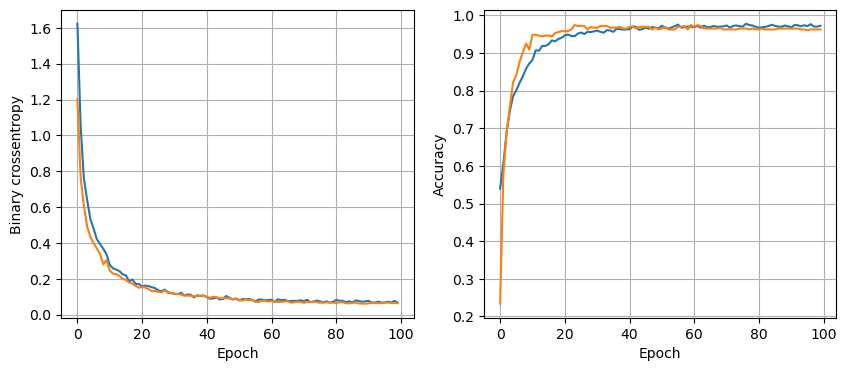

13/13 [==============================] - 0s 991us/step - loss: 0.0793 - accuracy: 0.9727
64 nodes, dropout 0, lr 0.01, batch size 16


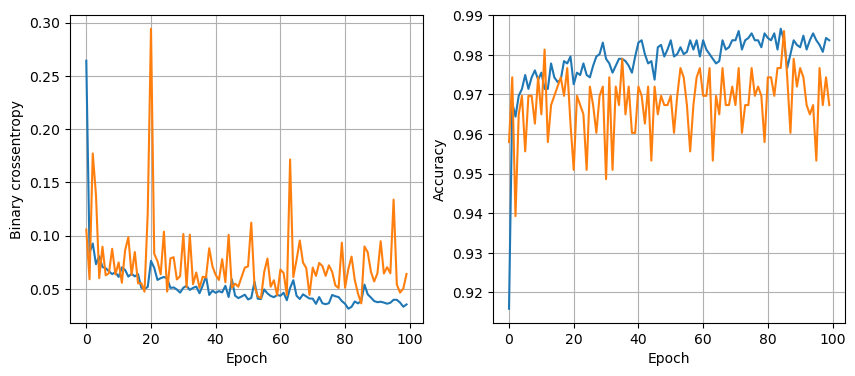

13/13 [==============================] - 0s 1ms/step - loss: 0.0761 - accuracy: 0.9777
64 nodes, dropout 0, lr 0.01, batch size 32


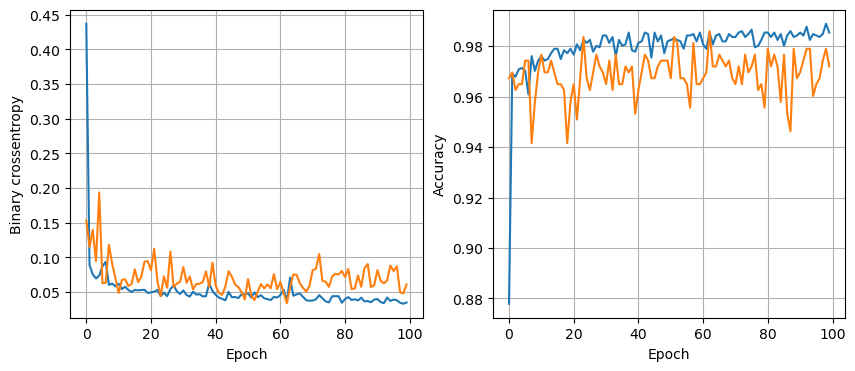

13/13 [==============================] - 0s 981us/step - loss: 0.0741 - accuracy: 0.9777
64 nodes, dropout 0, lr 0.01, batch size 64


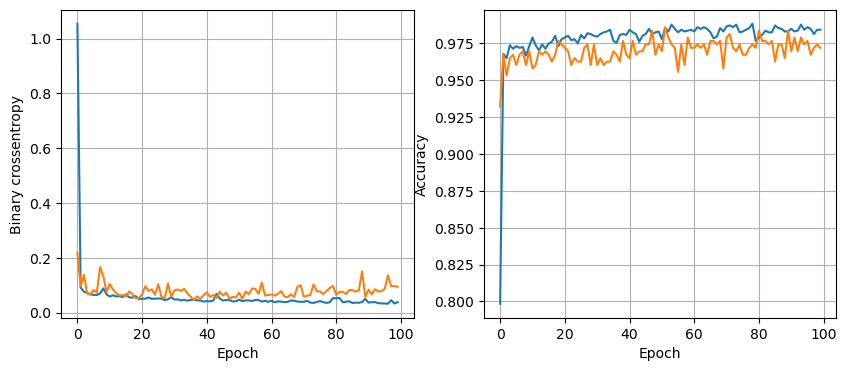

13/13 [==============================] - 0s 1ms/step - loss: 0.0698 - accuracy: 0.9801
64 nodes, dropout 0, lr 0.01, batch size 128


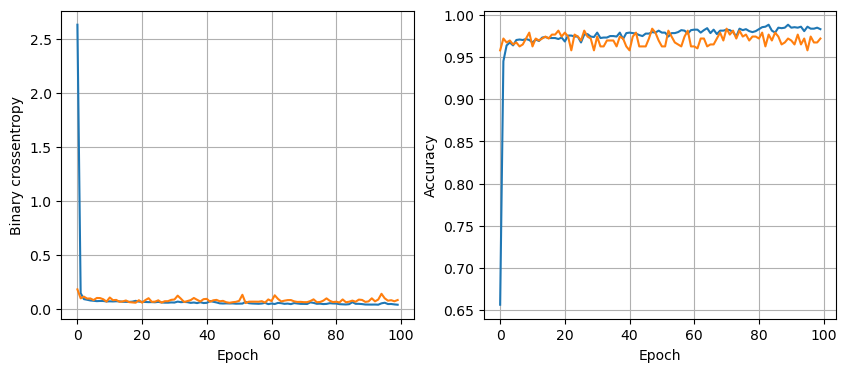

13/13 [==============================] - 0s 992us/step - loss: 0.0694 - accuracy: 0.9702
64 nodes, dropout 0, lr 0.005, batch size 16


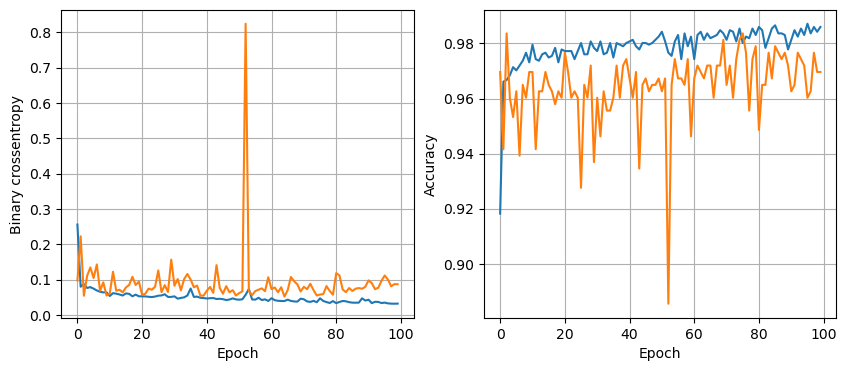

13/13 [==============================] - 0s 986us/step - loss: 0.0734 - accuracy: 0.9826
64 nodes, dropout 0, lr 0.005, batch size 32


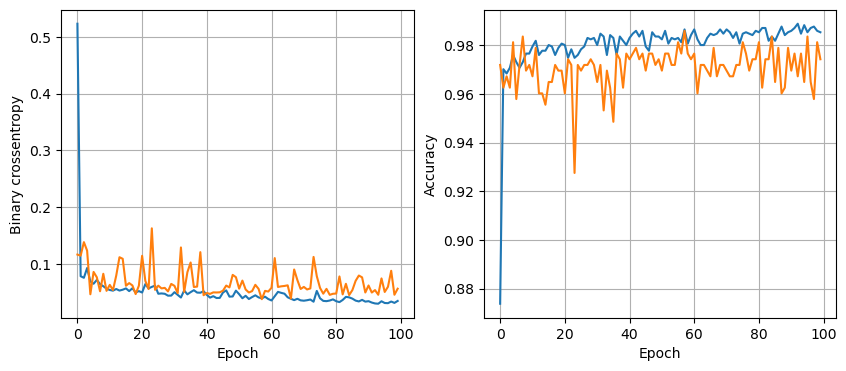

13/13 [==============================] - 0s 978us/step - loss: 0.0890 - accuracy: 0.9727
64 nodes, dropout 0, lr 0.005, batch size 64


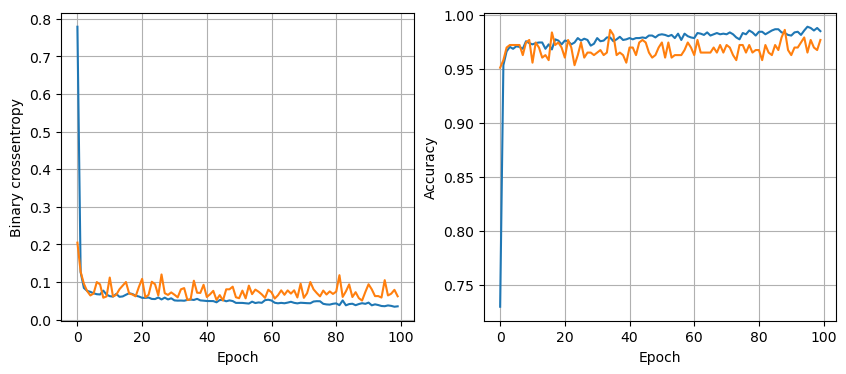

13/13 [==============================] - 0s 963us/step - loss: 0.0714 - accuracy: 0.9752
64 nodes, dropout 0, lr 0.001, batch size 16


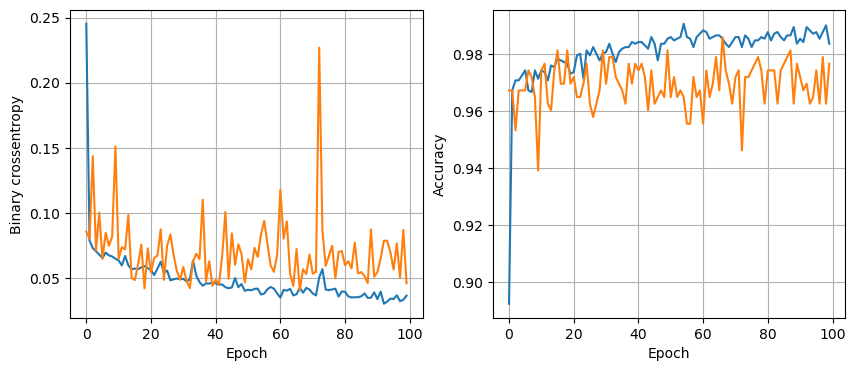

13/13 [==============================] - 0s 967us/step - loss: 0.0674 - accuracy: 0.9801
64 nodes, dropout 0, lr 0.001, batch size 32


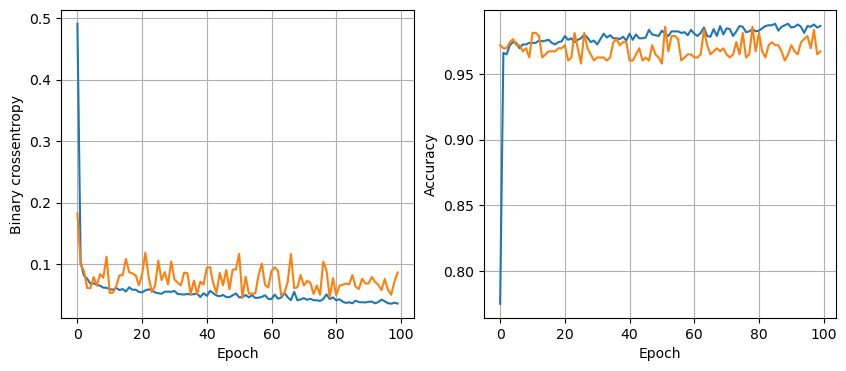

13/13 [==============================] - 0s 967us/step - loss: 0.0651 - accuracy: 0.9801
64 nodes, dropout 0, lr 0.001, batch size 64


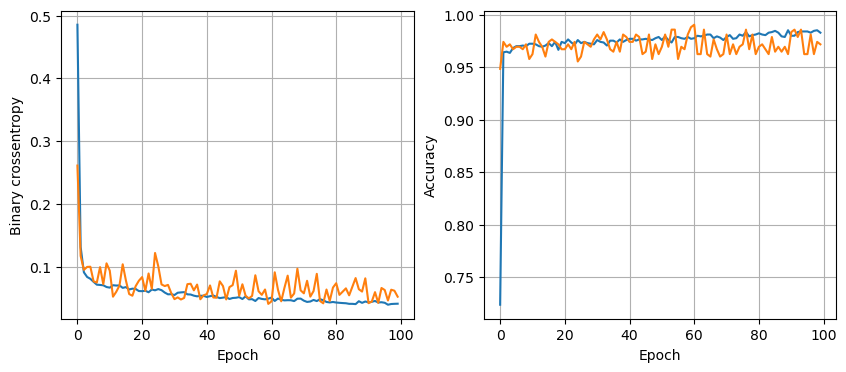

13/13 [==============================] - 0s 1ms/step - loss: 0.0715 - accuracy: 0.9752
64 nodes, dropout 0, lr 0.001, batch size 128


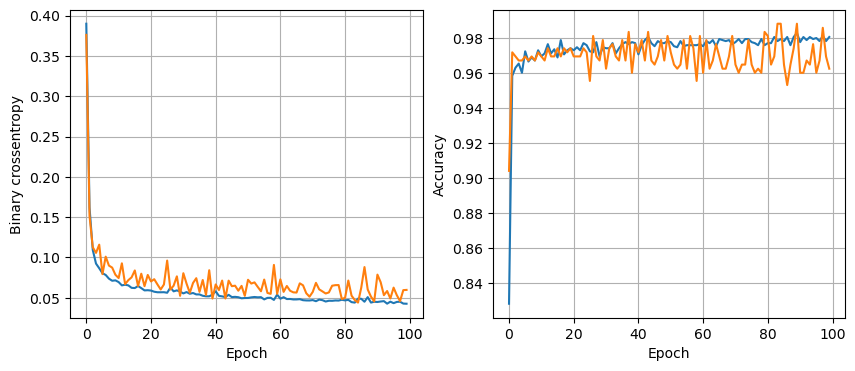

13/13 [==============================] - 0s 1ms/step - loss: 0.0680 - accuracy: 0.9752
64 nodes, dropout 0.2, lr 0.01, batch size 16


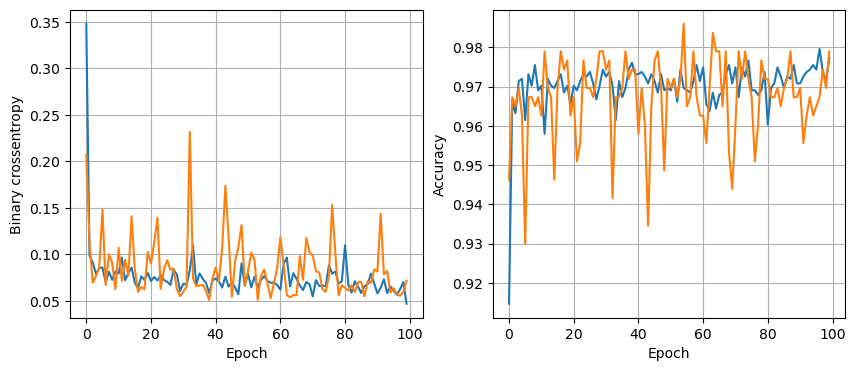

13/13 [==============================] - 0s 975us/step - loss: 0.0716 - accuracy: 0.9851
64 nodes, dropout 0.2, lr 0.01, batch size 32


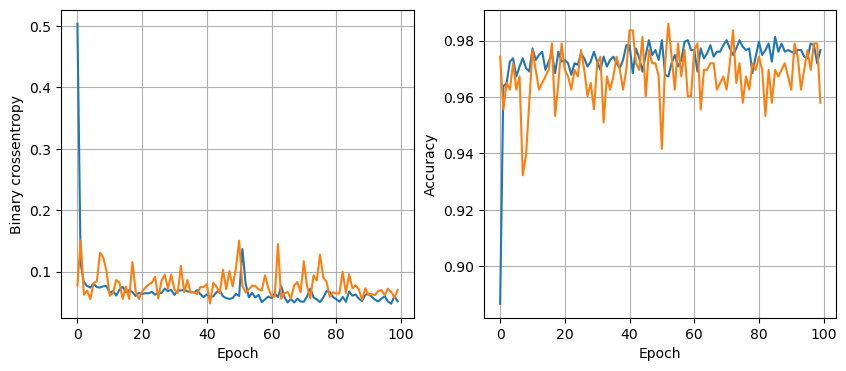

13/13 [==============================] - 0s 992us/step - loss: 0.0614 - accuracy: 0.9752
64 nodes, dropout 0.2, lr 0.01, batch size 64


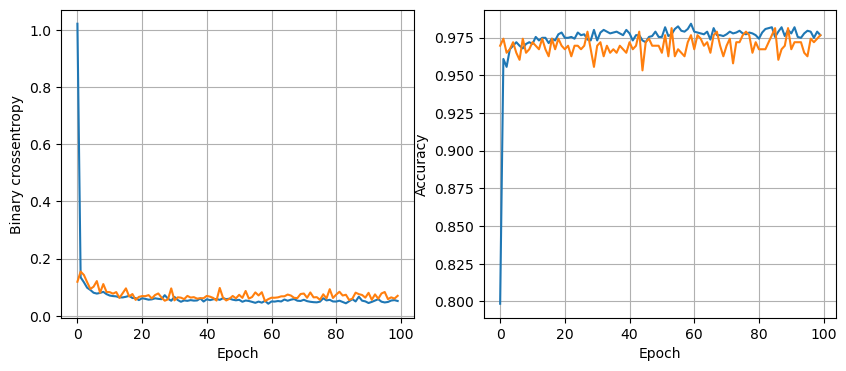

13/13 [==============================] - 0s 995us/step - loss: 0.0657 - accuracy: 0.9702
64 nodes, dropout 0.2, lr 0.01, batch size 128


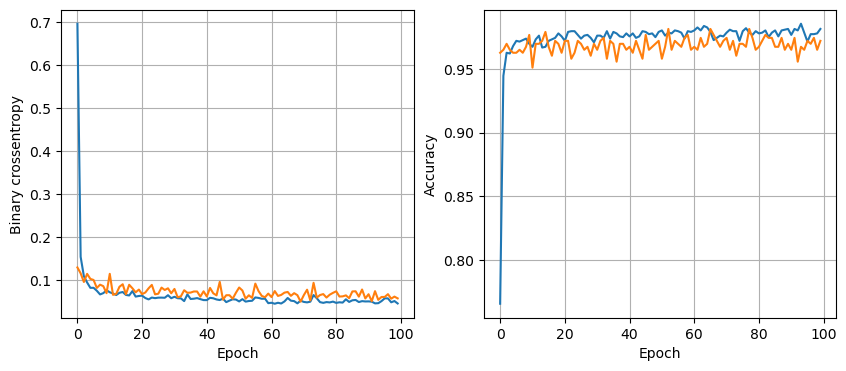

13/13 [==============================] - 0s 994us/step - loss: 0.0656 - accuracy: 0.9826
64 nodes, dropout 0.2, lr 0.005, batch size 16


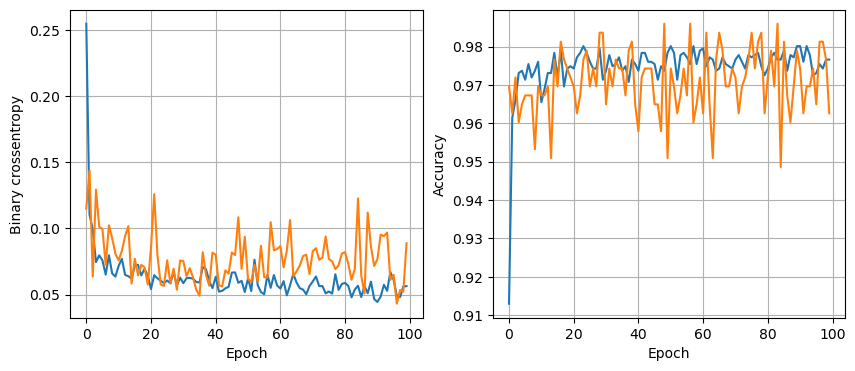

13/13 [==============================] - 0s 1ms/step - loss: 0.0592 - accuracy: 0.9777
64 nodes, dropout 0.2, lr 0.005, batch size 32


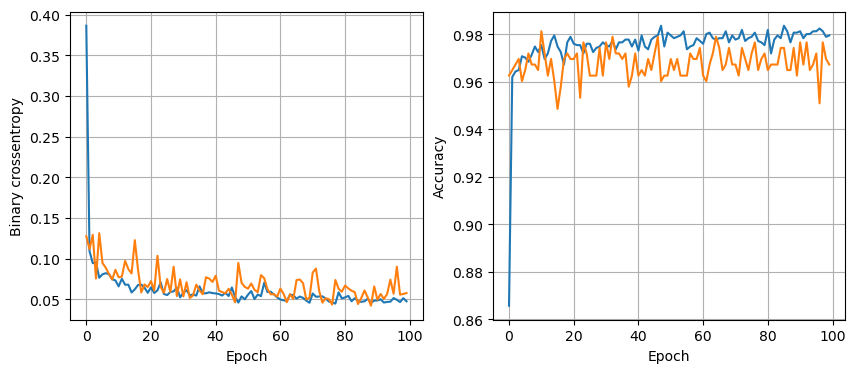

13/13 [==============================] - 0s 972us/step - loss: 0.0685 - accuracy: 0.9777
64 nodes, dropout 0.2, lr 0.005, batch size 64


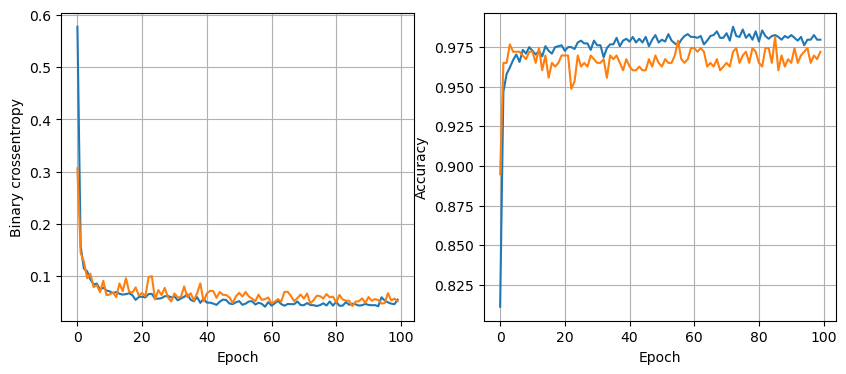

13/13 [==============================] - 0s 979us/step - loss: 0.0736 - accuracy: 0.9727
64 nodes, dropout 0.2, lr 0.005, batch size 128


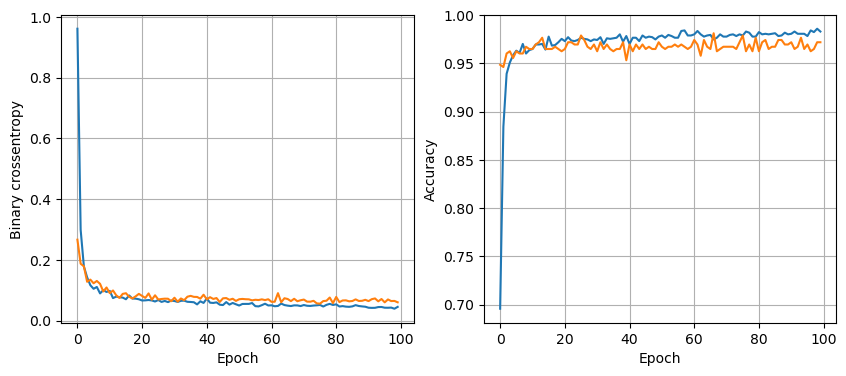

13/13 [==============================] - 0s 984us/step - loss: 0.0687 - accuracy: 0.9777
64 nodes, dropout 0.2, lr 0.001, batch size 16


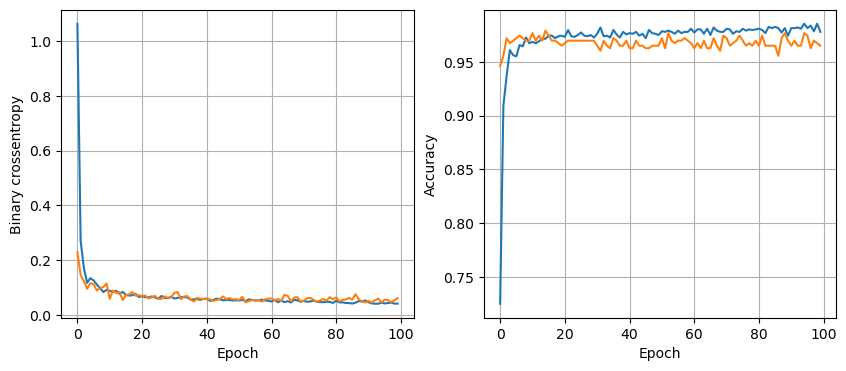

13/13 [==============================] - 0s 983us/step - loss: 0.0649 - accuracy: 0.9777
64 nodes, dropout 0.2, lr 0.001, batch size 32


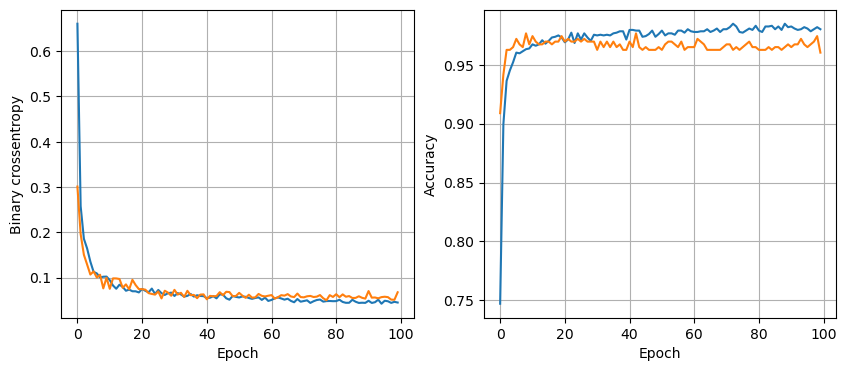

13/13 [==============================] - 0s 982us/step - loss: 0.0640 - accuracy: 0.9777
64 nodes, dropout 0.2, lr 0.001, batch size 64


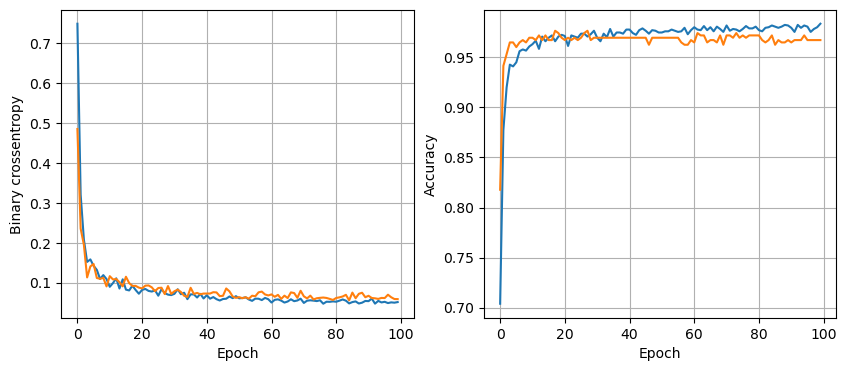

13/13 [==============================] - 0s 987us/step - loss: 0.0755 - accuracy: 0.9727
64 nodes, dropout 0.2, lr 0.001, batch size 128


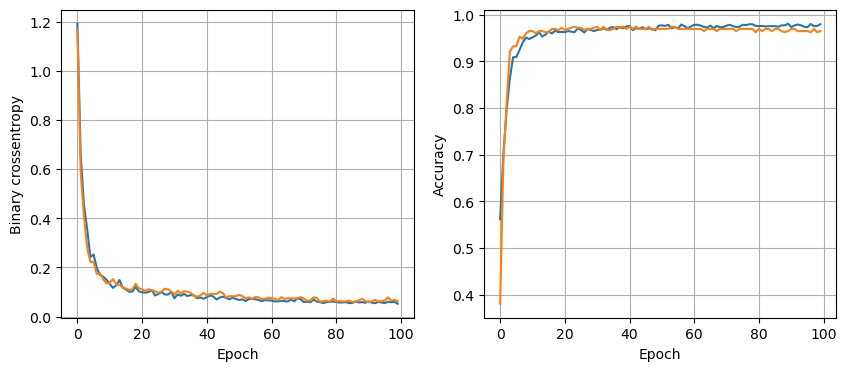

13/13 [==============================] - 0s 950us/step - loss: 0.0787 - accuracy: 0.9752


In [12]:
# to find the best specification for the neural nets
start_time = time.time()
least_val_loss = float('inf')
least_loss_model = None
epochs=100
for num_nodes in [4,8,16, 32, 64]:
  for dropout_prob in[0, 0.2]:
    for lr in [0.01, 0.005, 0.001]:
      for batch_size in [16,32, 64, 128]:
        print(f"{num_nodes} nodes, dropout {dropout_prob}, lr {lr}, batch size {batch_size}")
        model, history = train_model(x_train, y_train, num_nodes, dropout_prob, lr, batch_size, epochs)
        plot_history(history)
        val_loss = model.evaluate(x_valid, y_valid)[0]
        if val_loss < least_val_loss:
          least_val_loss = val_loss
          least_loss_model = model
end_time=time.time()

In [13]:
execution_time = end_time - start_time
print(f"Execution time: {execution_time} seconds")
print(f"Execution time: {execution_time/60} minutes")

Execution time: 1949.5044391155243 seconds
Execution time: 32.491740651925404 minutes


In [14]:
# EXECUTION TIME : 33MINS
# EXECUTION TIME WITH GPU : 32MINS

In [15]:
# testing our model's accuracy
from sklearn.metrics import classification_report
Y_pred = least_loss_model.predict(x_test)
Y_pred = (Y_pred > 0.5).astype(int).reshape(-1,)
print(classification_report(y_test, Y_pred))

13/13 [==============================] - 0s 682us/step
              precision    recall  f1-score   support

         0.0       0.98      0.98      0.98       232
         1.0       0.97      0.97      0.97       170

    accuracy                           0.98       402
   macro avg       0.97      0.97      0.97       402
weighted avg       0.98      0.98      0.98       402



In [16]:
# saving our model
least_loss_model.save('intel_cimta_gpu.h5')

/opt/intel/oneapi/intelpython/envs/tensorflow-gpu/lib/python3.9/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [17]:
from keras.models import load_model
model = load_model('intel_cimta_gpu.h5')

In [18]:
model.summary()

Model: "sequential_80"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_240 (Dense)           (None, 32)                160       
                                                                 
 dropout_160 (Dropout)       (None, 32)                0         
                                                                 
 dense_241 (Dense)           (None, 32)                1056      
                                                                 
 dropout_161 (Dropout)       (None, 32)                0         
                                                                 
 dense_242 (Dense)           (None, 1)                 33        
                                                                 
Total params: 1249 (4.88 KB)
Trainable params: 1249 (4.88 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
